# Dimensionality reduction on trial features

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from matplotlib import colors as mcolors
from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
import umap

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

In [2]:
# Full file path
file_path = os.path.join('/home/ines/repositories/representation_learning_variability/Exported figures/COSYNE25/')

In [3]:
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial/4_analyses/'
functions_path = '/home/ines/repositories/representation_learning_variability//Models/Sub-trial/4_analyses/'
os.chdir(functions_path)
states_trial_type = pd.read_pickle("./states_trial_type_14oct2024.pkl")  # obtained by running script 2.1
# states_trial_type = pd.read_pickle("./states_trial_type_w_paws_15oct2024.pkl")  # obtained by running script 2.1

extended = pd.read_pickle("./mouse_movements_df.pkl")
extended_short = extended[['trial_id', 'Bin', 'session', 'virtual_response', 'ballistic']]

In [4]:
merged = states_trial_type.merge(extended_short, on=['trial_id', 'Bin', 'session']).drop_duplicates()

## Extend states

In [5]:
extended_states = merged.copy()
extended_states['ori_states'] = extended_states['identifiable_states'].copy()

# New wheel states
# Wheel movement, no response
move_no_resp = extended_states.loc[(extended_states['virtual_response'].isna()) &
                                   (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response'].isna()) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'n' + move_no_resp.str[1:]
# Response L, non ballistic
left_non_ballistic = extended_states.loc[(extended_states['virtual_response']==1.) &
                                         (extended_states['ballistic']==False) &
                                         (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==1.) &
                    (extended_states['ballistic']==False) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'l' + left_non_ballistic.str[1:]
# Response R, non ballistic
right_non_ballistic = extended_states.loc[(extended_states['virtual_response']==-1.) &
                                          (extended_states['ballistic']==False) &
                                          (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==-1.) &
                    (extended_states['ballistic']==False) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'r' + right_non_ballistic.str[1:]

# Response L, ballistic
left_ballistic = extended_states.loc[(extended_states['virtual_response']==1.) &
                                     (extended_states['ballistic']==True) &
                                     (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==1.) &
                    (extended_states['ballistic']==True) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'L' + left_ballistic.str[1:]

# Response R, non ballistic
right_ballistic = extended_states.loc[(extended_states['virtual_response']==-1.) &
                                      (extended_states['ballistic']==True) &
                                      (extended_states['identifiable_states'].str[0]=='1'), 'identifiable_states']
extended_states.loc[(extended_states['virtual_response']==-1.) &
                    (extended_states['ballistic']==True) &
                    (extended_states['identifiable_states'].str[0]=='1'), 
                    'identifiable_states'] = 'R' + right_ballistic.str[1:]


## Parameters

In [6]:
bin_size = 0.1
multiplier = 1/bin_size

In [7]:
states_trial_type = extended_states.copy()
# states_trial_type = merged.copy()

In [8]:
def groupby(vars, use_data, feature_var):
    # Step 1: Group and count occurrences
    count = pd.DataFrame(use_data.groupby(vars)[feature_var].count())  #  'correct',

    # Step 2: Reset index to bring the grouping columns back into the DataFrame
    count = count.reset_index(level=list(np.arange(0, len(vars)-1, 1)))

    # Rename the count column
    count.rename(columns={feature_var: 'count'}, inplace=True)

    # Step 3: Calculate the total counts for each group of 'mouse_name', 'session', 'label'
    count['total'] = count.groupby(vars[:-1])['count'].transform('sum')  # 'broader_label'

    # Step 4: Compute the relative frequency
    count['relative_frequency'] = count['count'] / count['total']

    # Drop the 'total' column if it's no longer needed
    count = count.drop(columns=['total'])

    return count


In [9]:
# Fix wrong string in wsls
states_trial_type.loc[states_trial_type['wsls']=='ls', 'wsls'] = 'lst'

# Compute features and organize sample keys

In [10]:
trial_type_agg = ['wsls', 'correct_str', 'choice', 'contrast_str']
trial_type_agg = ['correct_str', 'contrast_str', 'wsls', 'choice']
trial_type_agg = ['correct_str', 'contrast_str', 'wsls', 'choice', 'virtual_response', 'ballistic']
# trial_type_agg = ['correct_str', 'contrast_str', 'wsls']
# trial_type_agg = ['correct_str', 'perseverence']
# trial_type_agg = ['wsls']
# trial_type_agg = ['correct_str', 'contrast_str', 'wsls', 'choice', 'virtual_response', 'ballistic']
trial_type_agg = ['correct_str', 'contrast_str']
trial_type_agg = ['correct_str']

order_0 = ['left', 'right']
order_1 = ['correct', 'incorrect']
order_1_1 = ['1.0',
    '0.25', 
    '0.125', 
    '0.0625', 
    '0.0']
order_1_2 = ['wst',
    'lst', 
    'wsh', 
    'lsh']


order_2 = ['correct 1.0',
    'correct 0.25', 
    'correct 0.125', 
    'correct 0.0625', 
    'correct 0.0', 
    'incorrect 1.0', 
    'incorrect 0.25', 
    'incorrect 0.125', 
    'incorrect 0.0625', 
    'incorrect 0.0']
order_2_1 = ['correct 1.0',
    'correct 0.25', 
    'correct 0.125', 
    'correct 0.0625', 
    'correct 0.0', 
    'incorrect 0.0', 
    'incorrect 0.0625', 
    'incorrect 0.125', 
    'incorrect 0.25', 
    'incorrect 1.0']
order_3 = ['correct 1.0 left', 'correct 1.0 right', 
    'correct 0.25 left', 'correct 0.25 right',
    'correct 0.125 left', 'correct 0.125 right',
    'correct 0.0625 left', 'correct 0.0625 right',
    'correct 0.0 left', 'correct 0.0 right',
    'incorrect 1.0 left', 'incorrect 1.0 right', 
    'incorrect 0.25 left', 'incorrect 0.25 right',
    'incorrect 0.125 left', 'incorrect 0.125 right',
    'incorrect 0.0625 left', 'incorrect 0.0625 right',
    'incorrect 0.0 left', 'incorrect 0.0 right']

order_4 = ['correct 1.0 wst', 'correct 1.0 wsh', 'correct 1.0 lst', 'correct 1.0 lsh', 
    'correct 0.25 wst', 'correct 0.25 wsh', 'correct 0.25 lst', 'correct 0.25 lsh', 
    'correct 0.125 wst', 'correct 0.125 wsh', 'correct 0.125 lst', 'correct 0.125 lsh',
    'correct 0.0625 wst', 'correct 0.0625 wsh',   'correct 0.0625 lst', 'correct 0.0625 lsh',
    'correct 0.0 wst', 'correct 0.0 wsh', 'correct 0.0 lst', 'correct 0.0 lsh',
    'incorrect 1.0 wst', 'incorrect 1.0 wsh',  'incorrect 1.0 lst', 'incorrect 1.0 lsh', 
    'incorrect 0.25 wst', 'incorrect 0.25 wsh', 'incorrect 0.25 lst', 'incorrect 0.25 lsh',
    'incorrect 0.125 wst', 'incorrect 0.125 wsh', 'incorrect 0.125 lst', 'incorrect 0.125 lsh',
    'incorrect 0.0625 wst', 'incorrect 0.0625 wsh',  'incorrect 0.0625 lst', 'incorrect 0.0625 lsh',
    'incorrect 0.0 wst', 'incorrect 0.0 wsh', 'incorrect 0.0 lst', 'incorrect 0.0 lsh']

order_5 = ['correct wst', 'correct lst', 'correct wsh', 'correct lsh',
    'incorrect wst', 'incorrect lst',  'incorrect wsh', 'incorrect lsh']

order_6 = ['correct stay', 'correct shift',
    'incorrect stay', 'incorrect shift']

use_order = order_1

In [11]:
""" Define trial types"""
states_trial_type['correct_str'] = states_trial_type['correct']
states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
states_trial_type.loc[states_trial_type['correct_str']==0., 'correct_str'] = 'incorrect'
states_trial_type['contrast_str'] = states_trial_type['contrast'].astype(str)
states_trial_type['perseverence'] = states_trial_type['wsls'].copy()
states_trial_type.loc[states_trial_type['wsls'].isin(['wst', 'lst']), 'perseverence']  = 'stay'
states_trial_type.loc[states_trial_type['wsls'].isin(['wsh', 'lsh']), 'perseverence']  = 'shift'
states_trial_type.loc[states_trial_type['ballistic']==True, 'ballistic'] = 1
states_trial_type.loc[states_trial_type['ballistic']==False, 'ballistic'] = 0
states_trial_type['trial_type'] = states_trial_type[trial_type_agg].agg(' '.join, axis=1)
states_trial_type['trial_str'] = states_trial_type['trial_id'].astype(str)
states_trial_type['sample'] = states_trial_type[['session', 'trial_str']].agg(' '.join, axis=1)

""" Filter trial types """
filtered_trials = states_trial_type.copy()

""" Frequency """
vars = ['sample', 'trial_type', 'broader_label', 'mouse_name']
extended_vars = ['sample', 'trial_type', 'broader_label', 'mouse_name', 'identifiable_states']
feature_var = 'identifiable_states'
count = groupby(extended_vars, filtered_trials, feature_var)

# Pivot the DataFrame
freq_df = count.reset_index().pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['identifiable_states', 'broader_label'], values='count')
# freq_df = count.reset_index().pivot(index=['sample', 'trial_type', 'mouse_name'], columns=['identifiable_states', 'broader_label'], values='relative_frequency')
# To flatten the column MultiIndex
freq_df.columns = ['_'.join(col).strip() for col in freq_df.columns.values]
freq_df[freq_df.isna()] = 0

# """ Timings """
# times = pd.DataFrame(states_trial_type.groupby(['sample', 'trial_type', 'mouse_name'])['reaction', 'response', 'elongation'].mean()).reset_index()

""" Original states and wheel states """
ballistic = pd.DataFrame(filtered_trials.groupby(['sample', 'trial_type', 'mouse_name'])['ballistic'].mean()).reset_index()
virtual_resp = pd.DataFrame(filtered_trials.groupby(['sample', 'trial_type', 'mouse_name'])['virtual_response'].mean()).reset_index()

# Merge
merged_df = freq_df.merge(ballistic, on=['sample', 'trial_type', 'mouse_name'])
merged_df = merged_df.merge(virtual_resp, on=['sample', 'trial_type', 'mouse_name'])

""" Filter trial types """
keep_trials =  ['correct 1.0',
    'correct 0.25']
# merged_df = merged_df.loc[merged_df['trial_type'].isin(keep_trials)]

# Add timestamp for each trial
merged_df = merged_df.merge(states_trial_type[['sample', 'goCueTrigger_times']].drop_duplicates(), on='sample')

## Prepare design matrix

In [12]:
var_names = merged_df.keys()[3:-3]
assert len(var_names) == 96 ## curently 96 = 4 trial epochs x 24 states

ori_X = np.array(merged_df[var_names]) #.values

print(np.shape(ori_X))

(10140, 96)


## UMAP

In [13]:
reducer = umap.UMAP(random_state= 42, n_components=2)
# reducer = umap.UMAP(n_components=2)

# Standardization using StandardScaler
scaler = StandardScaler()
standardized_X = scaler.fit_transform(ori_X)

# embedding = reducer.fit_transform(standardized_X)
# embedding.shape

embedding = reducer.fit_transform(ori_X)
embedding.shape


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(10140, 2)

In [14]:
merged_df['session'] = merged_df['sample'].str[:36]
use_key = 'trial_type' # session trial_typefilter

unique_numeric_labels = np.arange(0, len(use_order), 1)
map_to_use = dict(zip(use_order, unique_numeric_labels))

# Apply map
unique_trial_types = merged_df[use_key].unique()
# trial_type_map = dict(zip(unique_trial_types, unique_numeric_labels))
merged_df['numeric_trial_code'] = merged_df[use_key].map(map_to_use)

# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(merged_df['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(merged_df['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = merged_df['mouse_name'].map(map_mouse_names)

/tmp/ipykernel_8475/3602202474.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


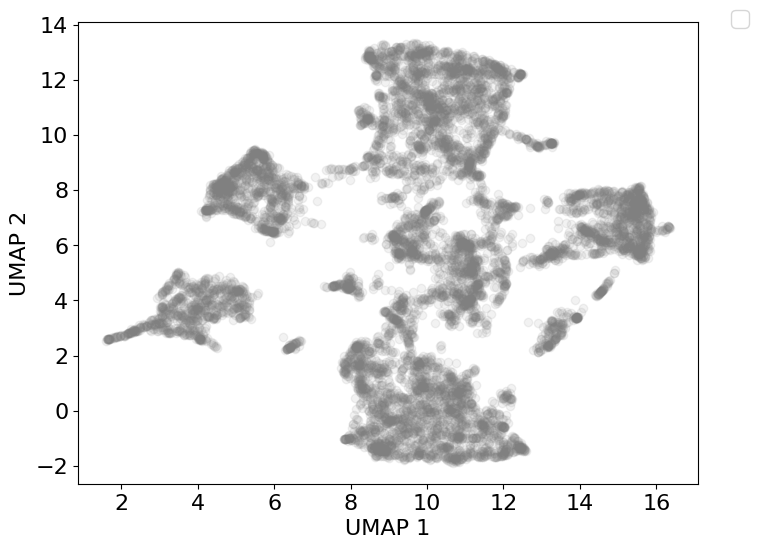

In [16]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})

# scatter = plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     alpha=0.3,
#     c=mouse_name_numbers,
#     cmap='viridis'  # Choose a colormap
# )   
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.1,
    c='grey'  # Choose a colormap
)   
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Save the figure as an SVG file
plt.savefig(file_path+'UMAP_grey', format="svg")


Text(0, 0.5, 'UMAP 2')

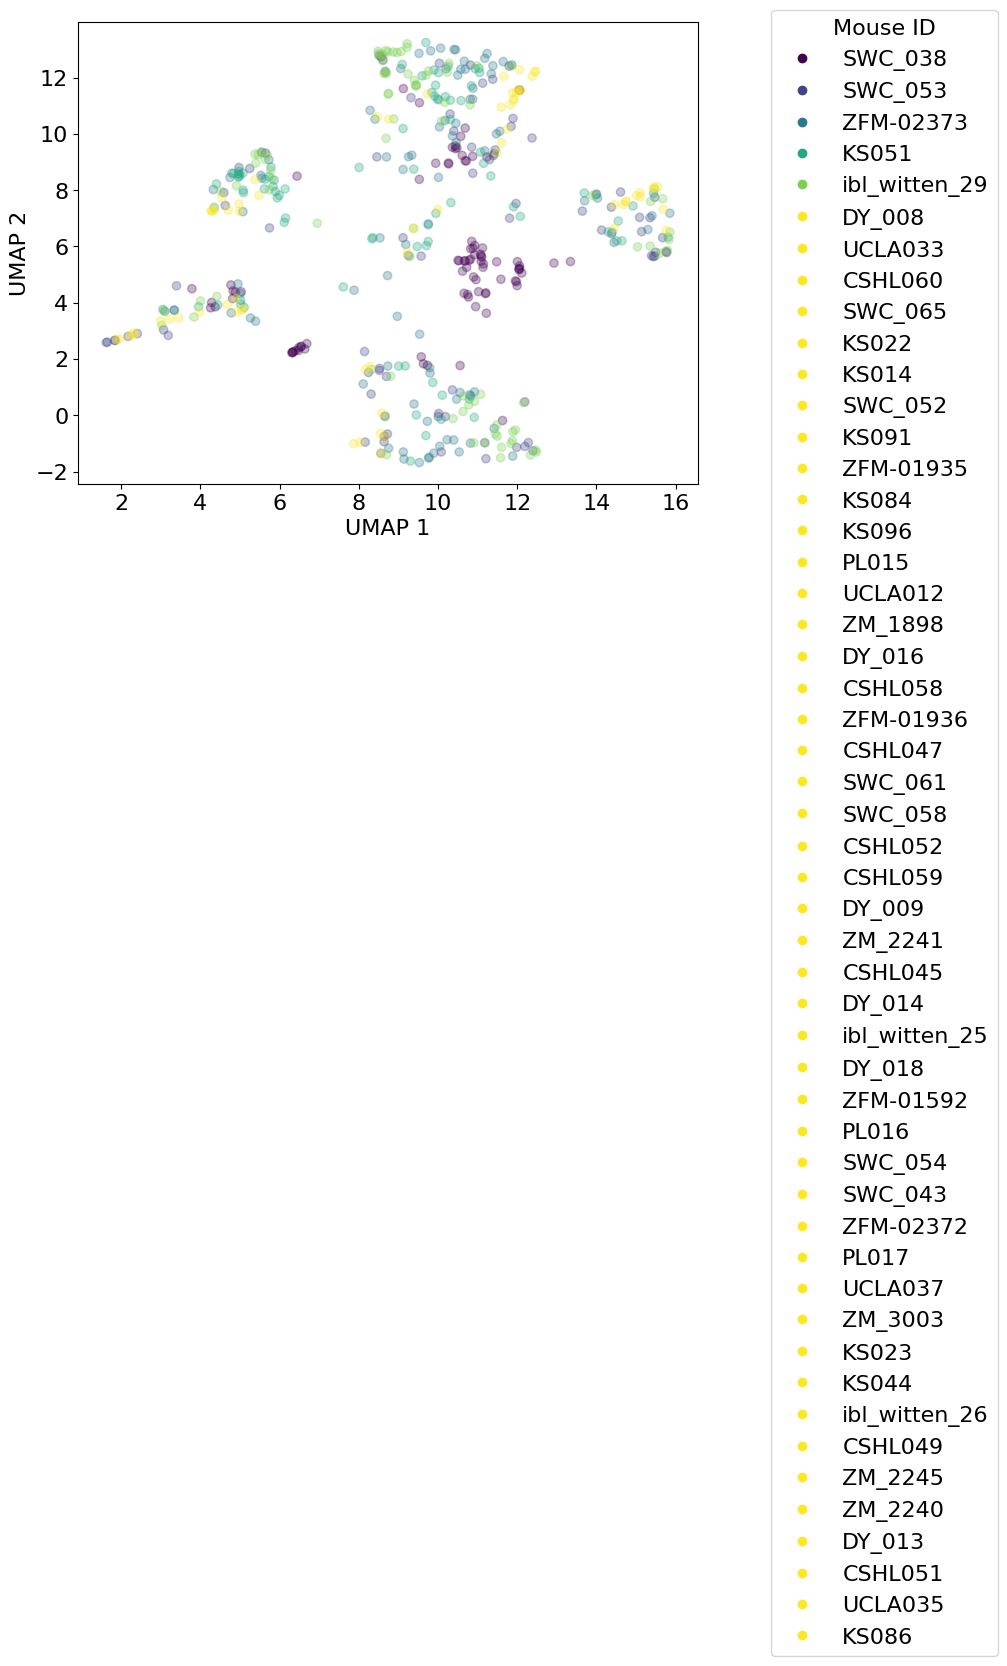

In [222]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    embedding[:, 0][0:500],
    embedding[:, 1][0:500],
    alpha=0.3,
    c=mouse_name_numbers[0:500],
    cmap='viridis'  # Choose a colormap
)   #     c=mouse_name_numbers,

# Create the custom legend
handles = []
for code, label in zip(unique_mouse_labels[:], merged_df['mouse_name'].unique()[:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

plt.legend(handles=handles, title="Mouse ID", bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")


Text(0, 0.5, 'UMAP 2')

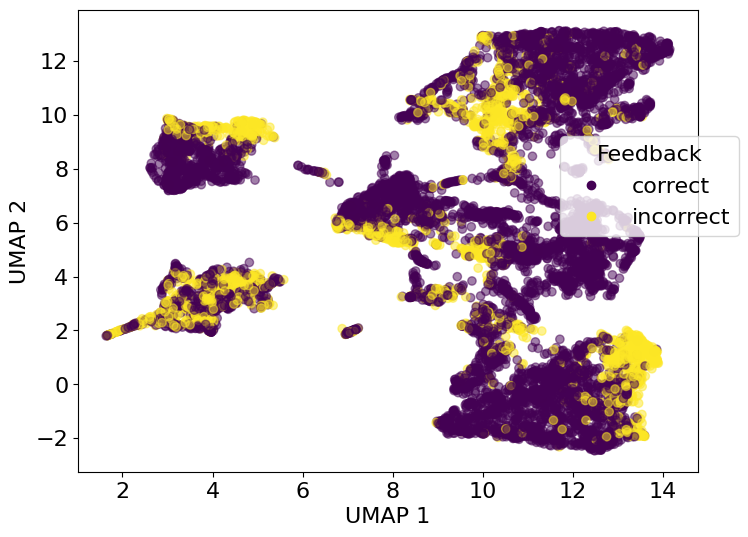

In [98]:
plt.figure(figsize=(8, 6))
filter = merged_df['trial_type'].isin(['incorrect stay', 'incorrect shift'])
filter = merged_df['trial_type'].isin(['correct stay', 'correct shift', 'incorrect stay', 'incorrect shift'])
filter = merged_df['trial_type'].isin(use_order)
plt.rcParams.update({'font.size': 16})

# Plotting the scatter plot
scatter = plt.scatter(
    embedding[:, 0][filter],
    embedding[:, 1][filter],
    c=merged_df.loc[filter, 'numeric_trial_code'],
    alpha=0.5,
    cmap='viridis'  # Choose a colormap
)  

# Create the custom legend
handles = []
for code, label in zip(unique_numeric_labels[0:], use_order[0:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

# x.legend(bbox_to_anchor=(1.1, 1.05))
plt.legend(handles=handles, title="Feedback", bbox_to_anchor=(.76, .75))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
# plt.xlim([-15, 25])
# plt.gca().set_aspect('equal', 'datalim')



# GMM to assess best k

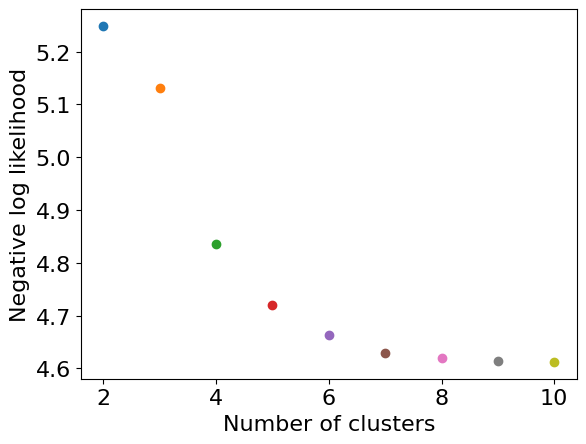

In [69]:
from sklearn import mixture

for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    # g = mixture.GaussianMixture(n_components=k)
    # generate random sample, two components
    np.random.seed(0)

    # concatenate the two datasets into the final training set
    cutoff = int(np.shape(embedding)[0]*0.8)
    X_train = np.vstack([embedding[:cutoff, 0], embedding[:cutoff, 1]]).T

    # fit a Gaussian Mixture Model with two components
    clf = mixture.GaussianMixture(n_components=k, covariance_type='full')
    clf.fit(X_train)

    X_test = np.vstack([embedding[cutoff:, 0], embedding[cutoff:, 1]])
    LL = -clf.score(X_test.T)
    
    plt.scatter([k], [LL])
    plt.xlabel('Number of clusters')
    plt.ylabel('Negative log likelihood')
    
    # Save the figure as an SVG file
    plt.savefig(file_path+'NLL_trials.svg', format="svg")


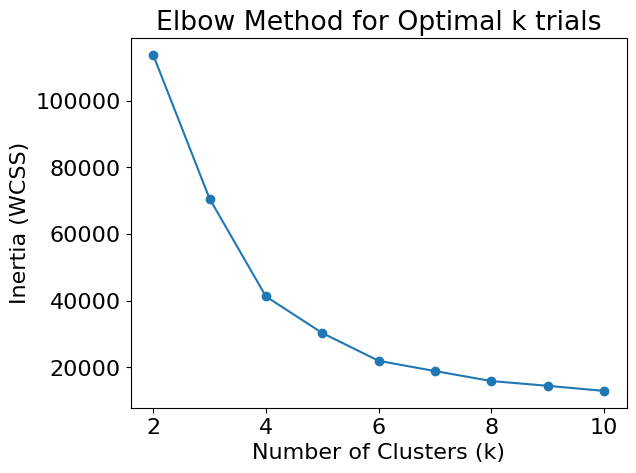

In [45]:
# Assuming `X` is your data
inertia_values = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(embedding)[0]*0.8)
    X_train = np.vstack([embedding[:cutoff, 0], embedding[:cutoff, 1]]).T
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)

# Plotting the inertia values
plt.plot(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k trials')
# Save the figure as an SVG file
plt.savefig(file_path+'inertia_trials.svg', format="svg")
plt.show()


## K-means clustering of data

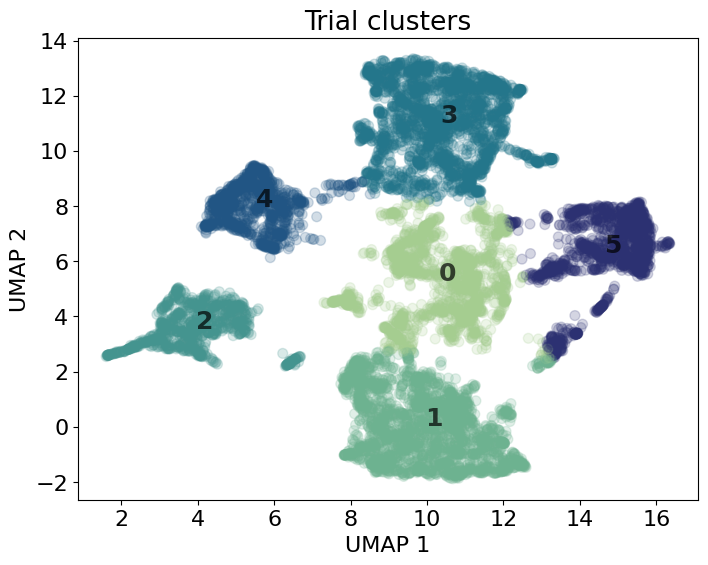

In [49]:
# Step 2: Perform KMeans Clustering
data_2d = embedding
kmeans_trials = KMeans(n_clusters=6, random_state=2024)
kmeans_trials.fit(data_2d)
y_kmeans_trials = kmeans_trials.predict(data_2d)
plt.rcParams.update({'font.size': 16})

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))

# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=y_kmeans_trials, s=50, alpha=0.2, cmap=sns.color_palette("crest", as_cmap=True)) # , cmap='Set2'

# Plot the centroids
centroids = kmeans_trials.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')




plt.title("Trial clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# Save the figure as an SVG file
plt.savefig(file_path+'clusters_trials_1.svg', format="svg")
plt.show()


In [16]:
# Analyze state features
merged_df['cluster'] = y_kmeans_trials
df_cluster = count.reset_index().merge(merged_df[['sample', 'cluster', 'session',  'goCueTrigger_times']], on='sample')
# df_cluster = df_cluster.merge(sum[['sample', 'broader_label', 'sum']], on=['sample', 'broader_label'])
df_cluster = df_cluster.merge(states_trial_type[['sample', 'reaction', 'response', 'elongation', 'perseverence', 
                                                 'choice', 'contrast', 'wsls', 'correct']].drop_duplicates(), on=['sample'])
df_cluster = df_cluster.merge(ballistic[['sample', 'ballistic']], on=['sample'])


In [16]:
# df_cluster.to_pickle("./cluster_per_trial_14oct2024.pkl")  

/tmp/ipykernel_8475/147522164.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='reaction', data=df_cluster, palette='Set2')
/tmp/ipykernel_8475/147522164.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


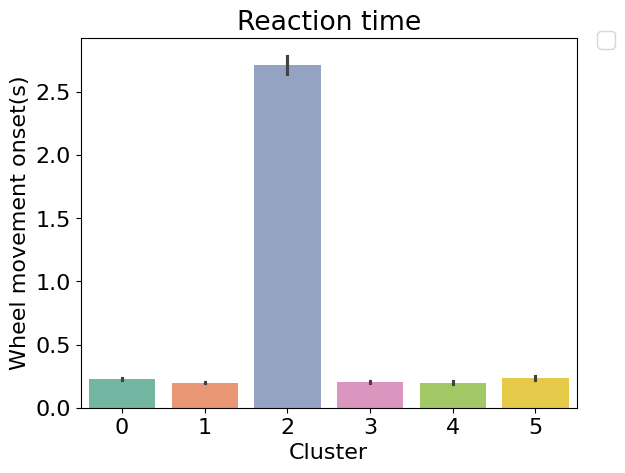

/tmp/ipykernel_8475/147522164.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='response', data=df_cluster, palette='Set2')
/tmp/ipykernel_8475/147522164.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


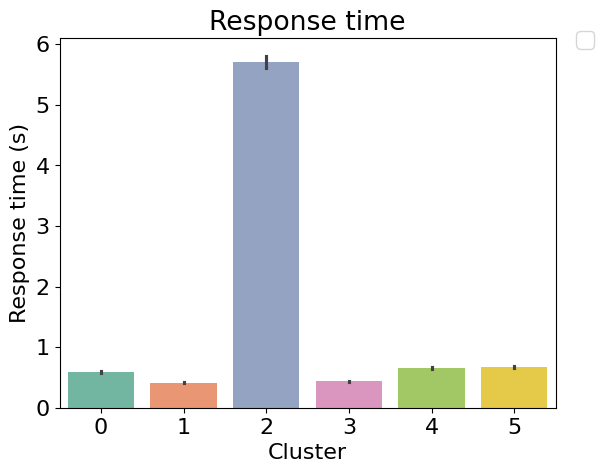

/tmp/ipykernel_8475/147522164.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='elongation', data=df_cluster, palette='Set2')
/tmp/ipykernel_8475/147522164.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


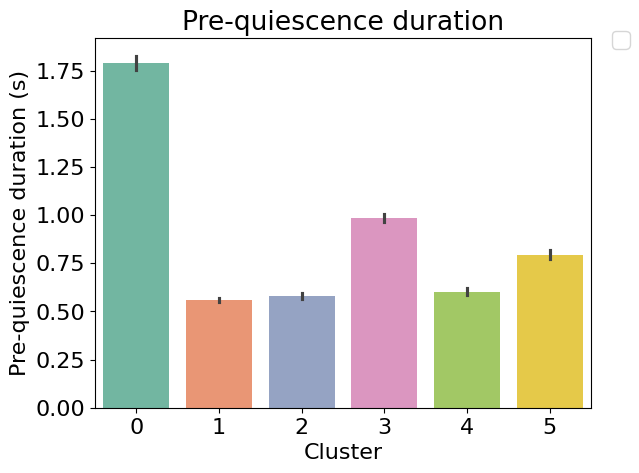

/tmp/ipykernel_8475/147522164.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='ballistic', data=df_cluster, palette='Set2')
/tmp/ipykernel_8475/147522164.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


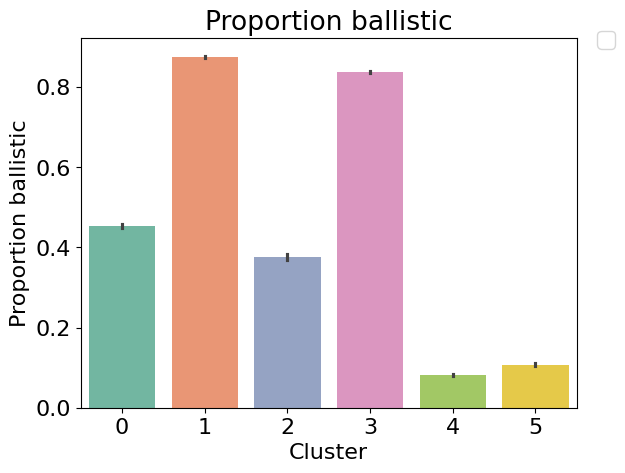

/tmp/ipykernel_8475/147522164.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cluster', y='correct', data=df_cluster, palette='Set2')
/tmp/ipykernel_8475/147522164.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


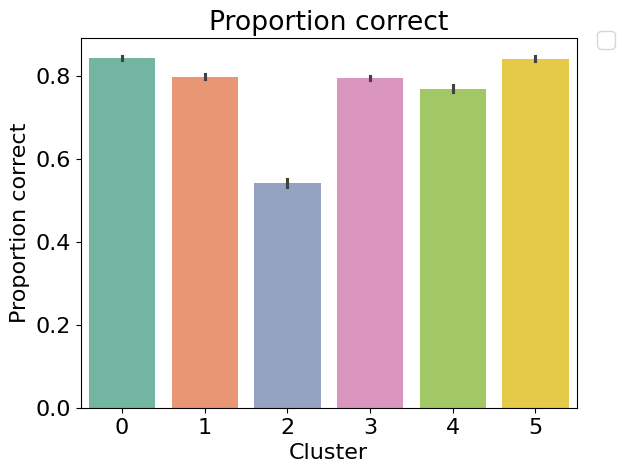

In [22]:
sns.barplot(x='cluster', y='reaction', data=df_cluster, palette='Set2')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Reaction time')
plt.ylabel('Wheel movement onset(s)')
plt.xlabel('Cluster')
plt.savefig(file_path+'reaction', format="svg")
plt.show()

sns.barplot(x='cluster', y='response', data=df_cluster, palette='Set2')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time')
plt.ylabel('Response time (s)')
plt.xlabel('Cluster')
plt.savefig(file_path+'response', format="svg")
plt.show()

sns.barplot(x='cluster', y='elongation', data=df_cluster, palette='Set2')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Pre-quiescence duration')
plt.ylabel('Pre-quiescence duration (s)')
plt.xlabel('Cluster')
plt.savefig(file_path+'elongation', format="svg")
plt.show()

sns.barplot(x='cluster', y='ballistic', data=df_cluster, palette='Set2')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion ballistic')
plt.ylabel('Proportion ballistic')
plt.xlabel('Cluster')
plt.savefig(file_path+'ballistic', format="svg")
plt.show()

sns.barplot(x='cluster', y='correct', data=df_cluster, palette='Set2')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion correct')
plt.ylabel('Proportion correct')
plt.xlabel('Cluster')
# plt.ylim([.6, .9])
plt.savefig(file_path+'correct', format="svg")
plt.show()

# use_data = df_cluster.copy()
# use_data.loc[use_data['choice']=='left', 'choice'] = 1
# use_data.loc[use_data['choice']=='right', 'choice'] = 0
# sns.barplot(x='cluster', y='choice', data=use_data, palette='Set2')
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.title('Choice')
# plt.ylabel('Proportion choice left')
# plt.xlabel('Cluster')
# plt.show()

# sns.barplot(x='cluster', y='contrast', data=df_cluster, palette='Set2')
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.title('Mean contrast')
# plt.ylabel('Mean contrast')
# plt.xlabel('Cluster')
# plt.show()


/tmp/ipykernel_1032282/2142966427.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


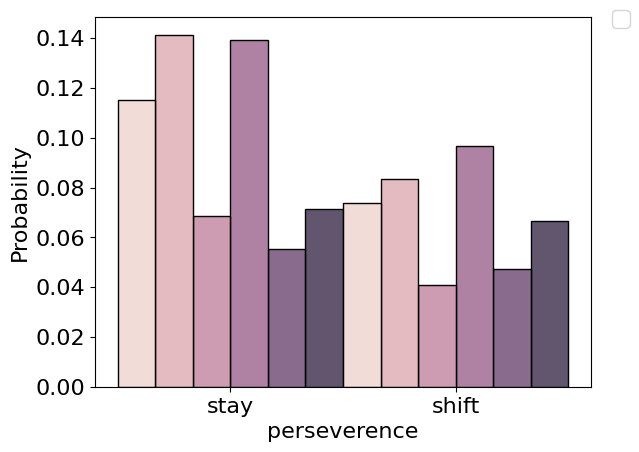

In [18]:
sns.histplot(x='perseverence', hue='cluster', data=df_cluster, stat='probability', multiple='dodge')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('')
plt.show()


In [17]:
def revert_to_original(use_data):
    # Revert to original states
    use_data['original_states'] = use_data['identifiable_states'].copy()

    state = use_data.loc[use_data['original_states'].str[0]=='L', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='L', 'original_states'] = '1' + state.str[1:]

    state = use_data.loc[use_data['original_states'].str[0]=='l', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='l', 'original_states'] = '1' + state.str[1:]

    state = use_data.loc[use_data['original_states'].str[0]=='R', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='R', 'original_states'] = '1' + state.str[1:]

    state = use_data.loc[use_data['original_states'].str[0]=='r', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='r', 'original_states'] = '1' + state.str[1:]


    state = use_data.loc[use_data['original_states'].str[0]=='n', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='n', 'original_states'] = '1' + state.str[1:]
    
    return use_data

def get_ballistic(use_data):
    use_data['bal_state'] = use_data['identifiable_states'].copy()
    use_data.loc[use_data['identifiable_states'].str[0]=='L', 'bal_state'] = 'balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='R', 'bal_state'] = 'balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='l', 'bal_state'] = 'non_balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='r', 'bal_state'] = 'non_balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='n', 'bal_state'] = 'non_balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='0', 'bal_state'] = np.nan

    return use_data

/tmp/ipykernel_53158/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


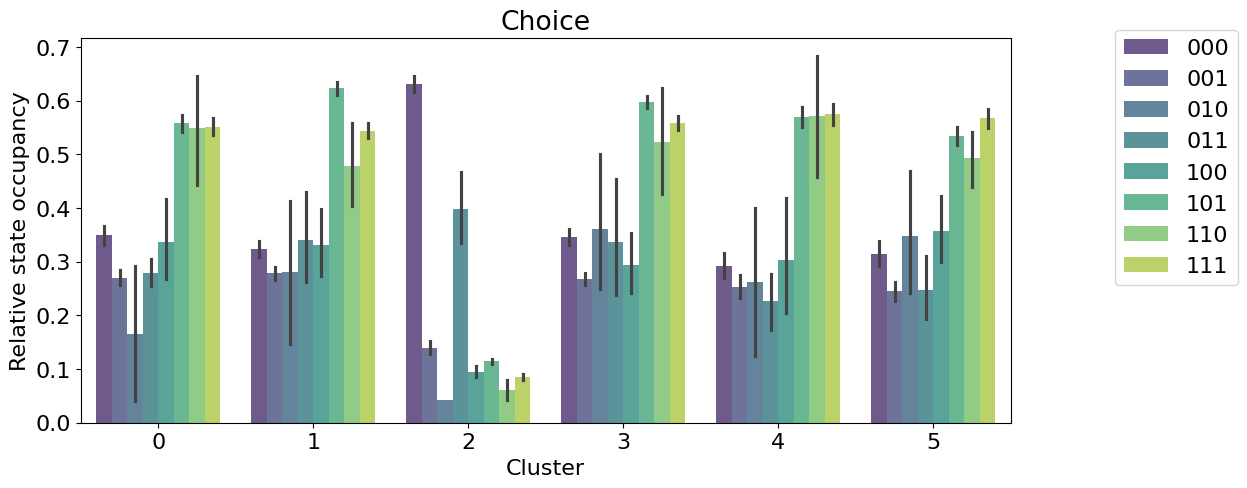

/tmp/ipykernel_53158/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


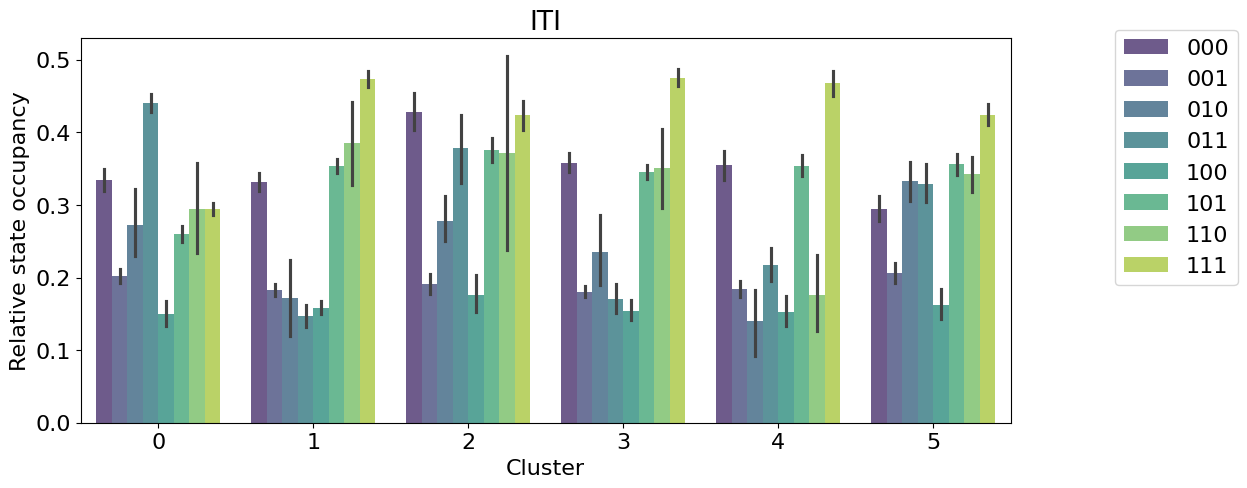

/tmp/ipykernel_53158/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


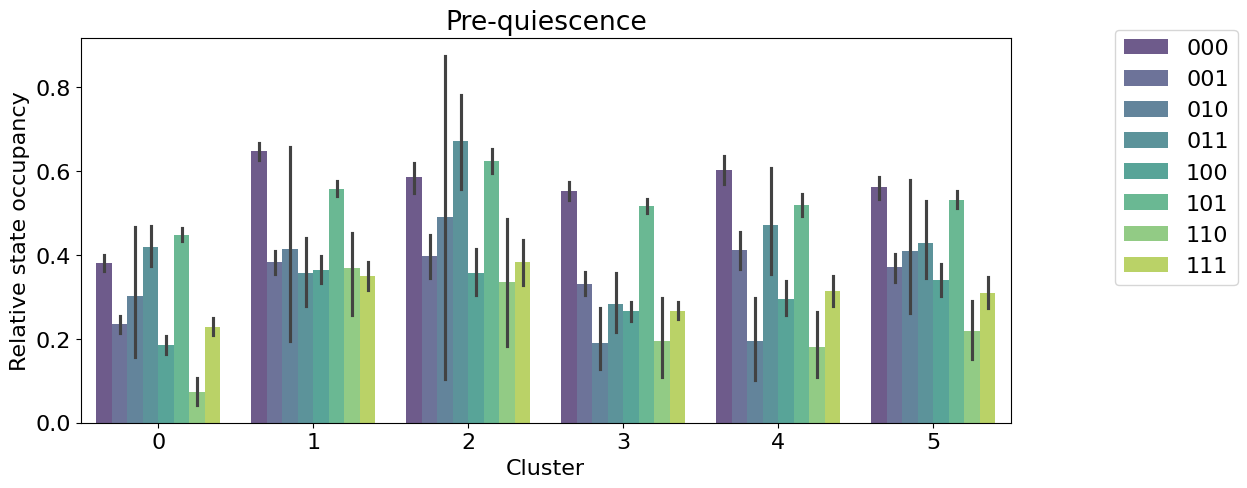

/tmp/ipykernel_53158/4245298614.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


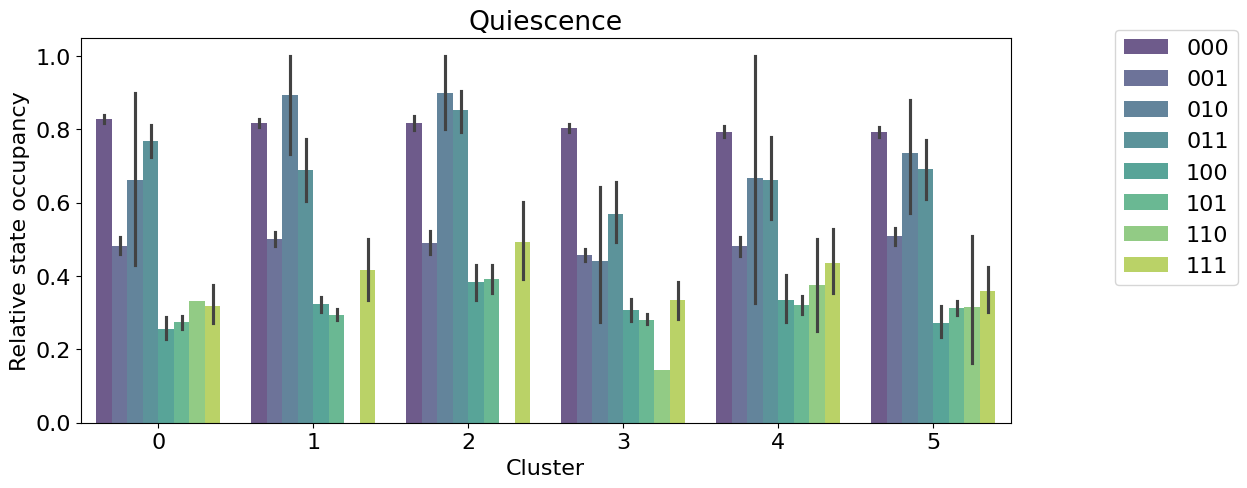

In [34]:
for e, epoch in enumerate(df_cluster['broader_label'].unique()):
    use_data = df_cluster.loc[df_cluster['broader_label']==epoch]
    use_data = revert_to_original(use_data)
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(hue='original_states', y='relative_frequency', x='cluster', alpha=0.8,
                hue_order = ['000', '001', '010', '011', '100', '101', '110','111'], data=use_data, palette='viridis')
    plt.xlabel('Cluster')
    plt.ylabel('Relative state occupancy')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

## Plot ballistic stats per cluster

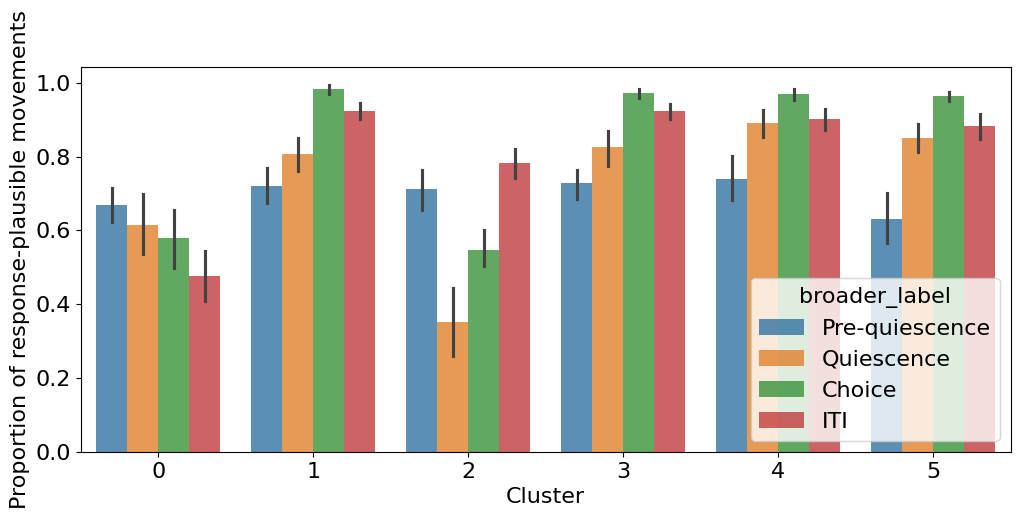

In [39]:
use_data = df_cluster.copy()
use_data = get_no_resp(use_data)
use_data.loc[use_data['resp']=='response', 'resp'] = 1
use_data.loc[use_data['resp']=='non_response', 'resp'] = 0
use_data = pd.DataFrame(use_data.groupby(['broader_label', 'cluster', 'mouse_name'])['resp'].mean()).reset_index()
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='cluster', y='resp', hue='broader_label', alpha=0.8,
            data=use_data, hue_order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI']) # hue_order=['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI']
plt.xlabel('Cluster')
plt.ylabel('Proportion of response-plausible movements')
plt.show()

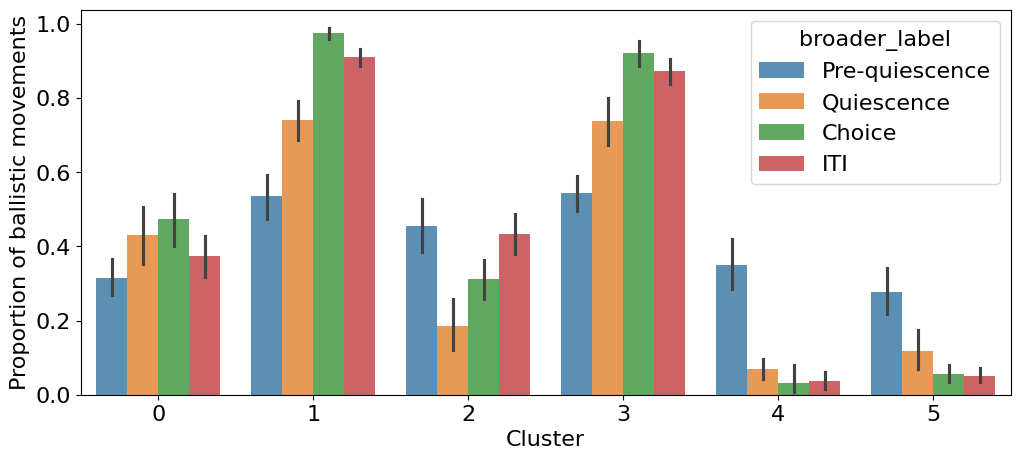

In [41]:
use_data = df_cluster.copy()
use_data = get_ballistic(use_data)
use_data.loc[use_data['bal_state']=='balistic', 'bal_state'] = 1
use_data.loc[use_data['bal_state']=='non_balistic', 'bal_state'] = 0
use_data = pd.DataFrame(use_data.groupby(['broader_label', 'cluster', 'mouse_name'])['bal_state'].mean()).reset_index()
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x='cluster', y='bal_state', hue='broader_label', alpha=0.8,
            data=use_data, hue_order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'])
plt.xlabel('Cluster')
plt.ylabel('Proportion of ballistic movements')
plt.show()

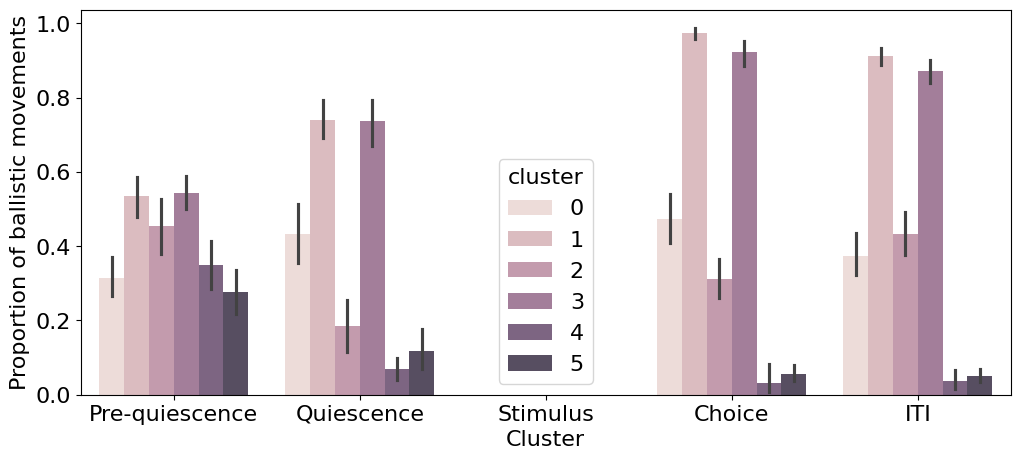

In [42]:
use_data = df_cluster.copy()
use_data = get_ballistic(use_data)
use_data.loc[use_data['bal_state']=='balistic', 'bal_state'] = 1
use_data.loc[use_data['bal_state']=='non_balistic', 'bal_state'] = 0
use_data = pd.DataFrame(use_data.groupby(['broader_label', 'cluster', 'mouse_name'])['bal_state'].mean()).reset_index()
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(hue='cluster', y='bal_state', x='broader_label', alpha=0.8,
            data=use_data, order=['Pre-quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI']) #, hue_order=['Pre_quiescence', 'Quiescence', 'Stimulus', 'Choice', 'ITI'])
plt.xlabel('Cluster')
plt.ylabel('Proportion of ballistic movements')
plt.show()

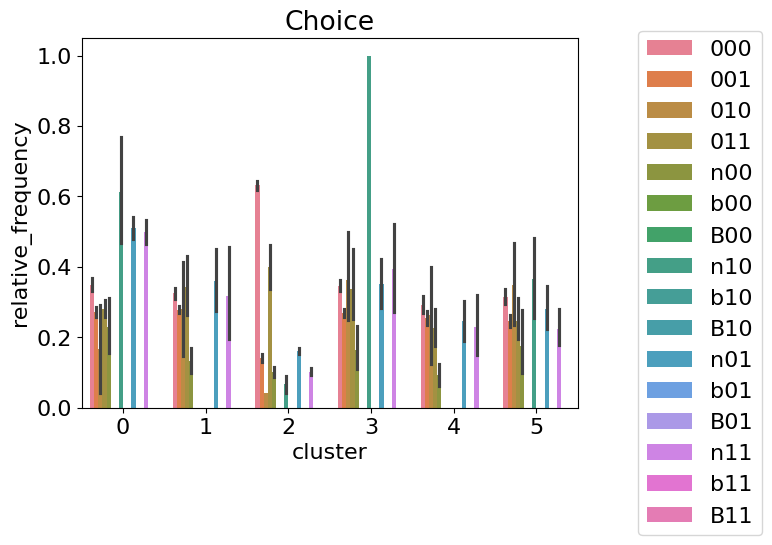

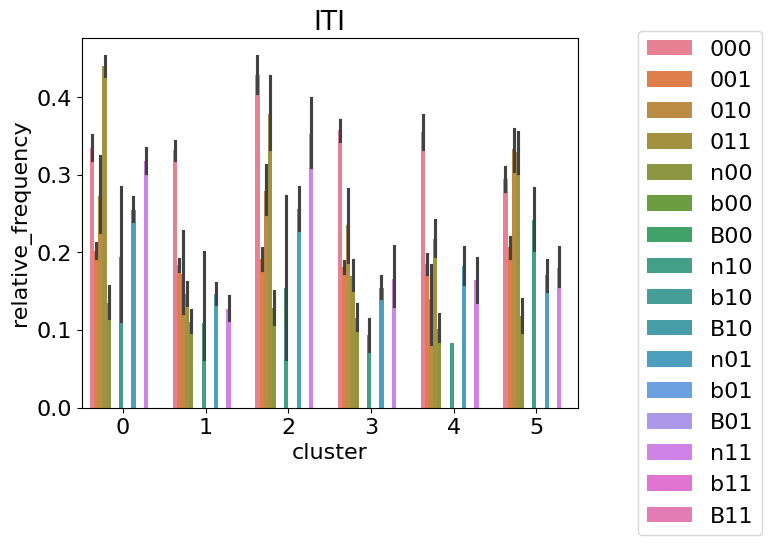

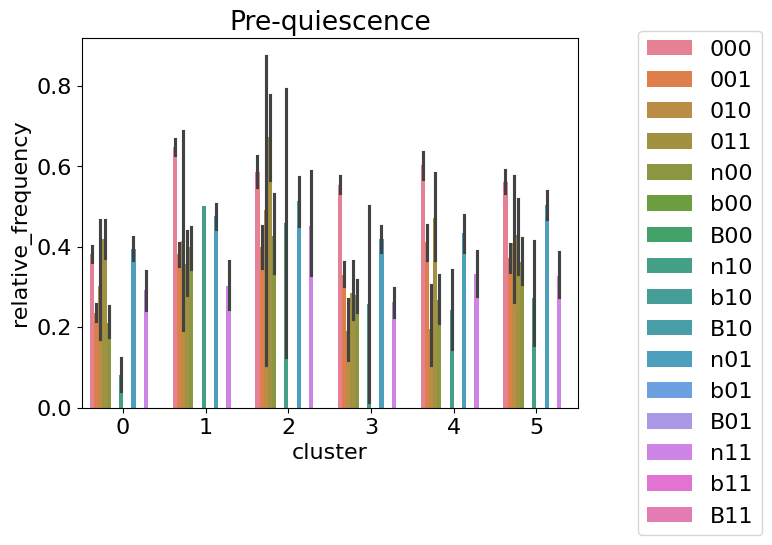

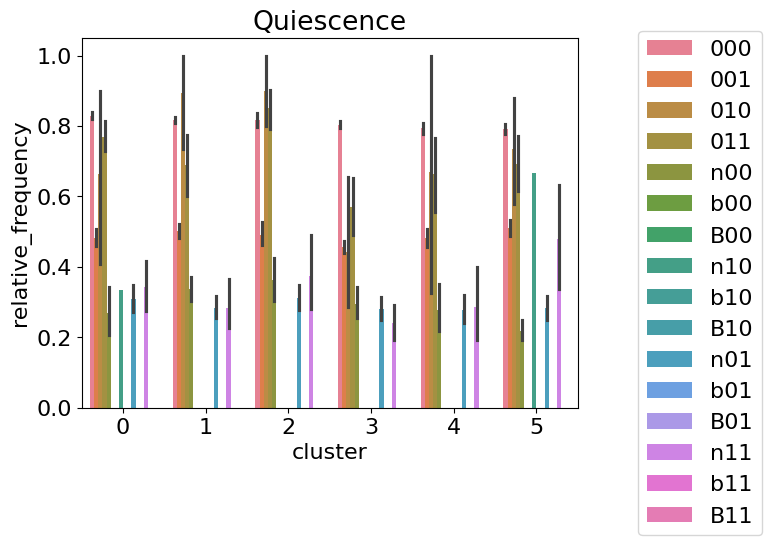

In [44]:
for e, epoch in enumerate(df_cluster['broader_label'].unique()):
    use_data = df_cluster.loc[df_cluster['broader_label']==epoch]
    sns.barplot(hue='identifiable_states', y='relative_frequency', x='cluster', 
                hue_order = ['000', '001', '010', '011', 'n00', 'b00', 'B00',
                             'n10', 'b10', 'B10', 'n01', 'b01', 'B01', 'n11', 'b11', 'B11'], data=use_data)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title(epoch)
    plt.show()

/tmp/ipykernel_53158/3439115826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


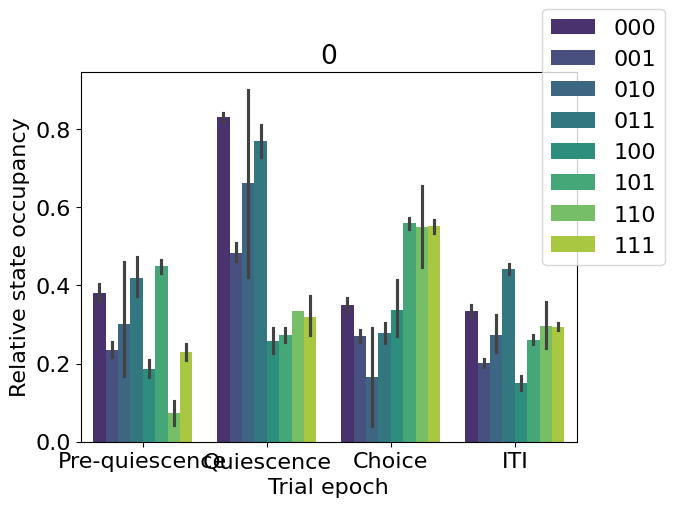

/tmp/ipykernel_53158/3439115826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


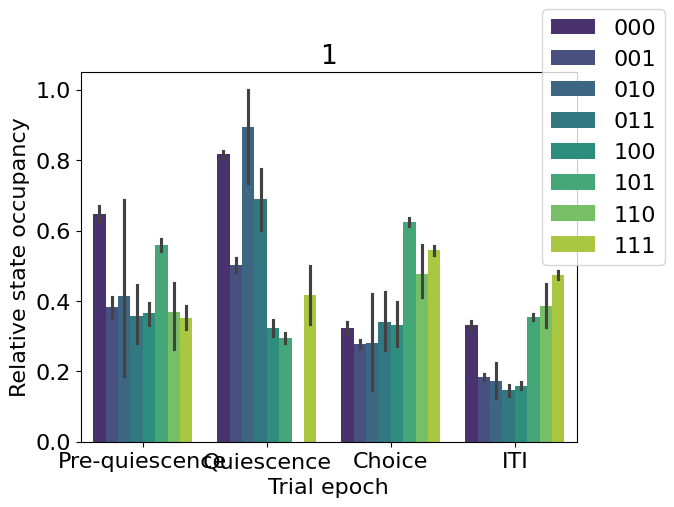

/tmp/ipykernel_53158/3439115826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


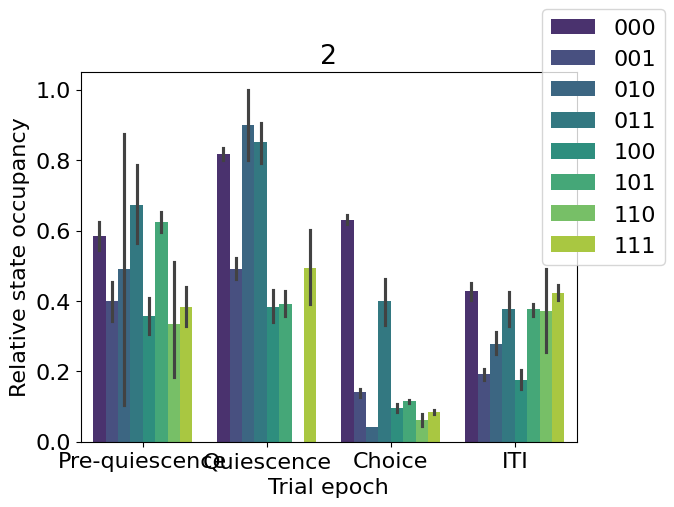

/tmp/ipykernel_53158/3439115826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


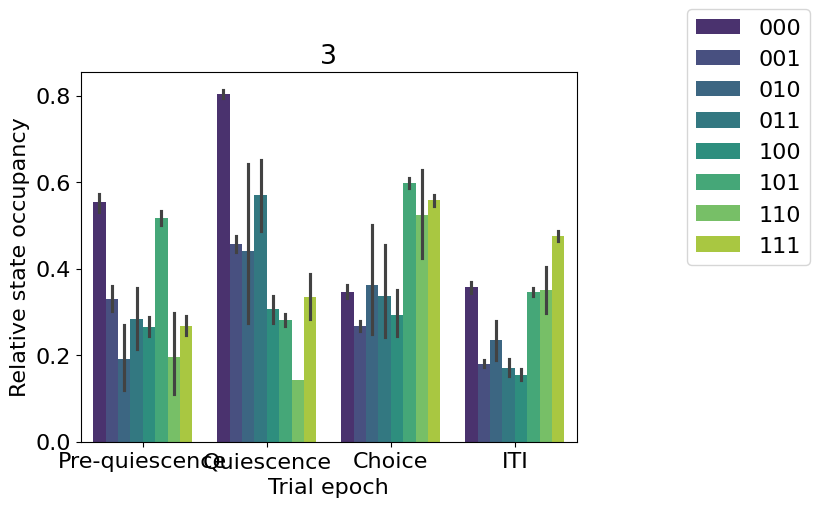

/tmp/ipykernel_53158/3439115826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


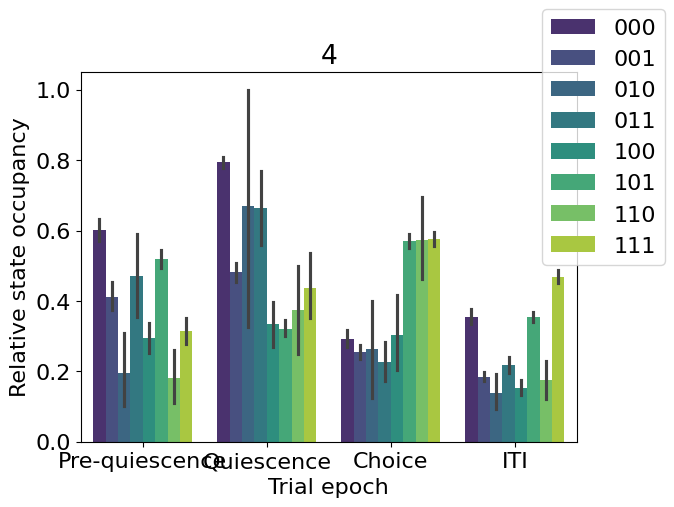

/tmp/ipykernel_53158/3439115826.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['original_states'] = use_data['identifiable_states'].copy()


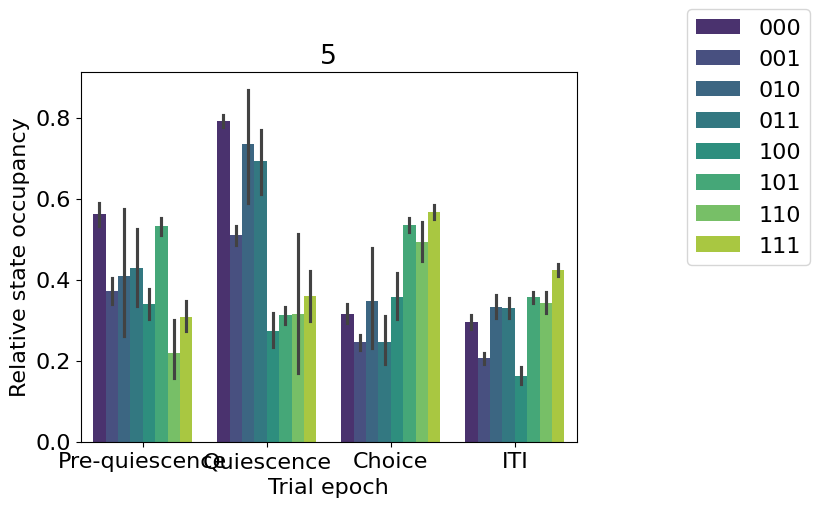

In [46]:
for c, cluster in enumerate(range(6)):
    use_data = df_cluster.loc[df_cluster['cluster']==cluster]
    use_data = revert_to_original(use_data)
    sns.barplot(x='broader_label', y='relative_frequency', hue='original_states', 
                order=['Pre-quiescence', 'Quiescence', 'Choice', 'ITI'], 
                hue_order = ['000', '001', '010', '011', '100', '101', '110','111'], data=use_data, palette='viridis')
    plt.xlabel('Trial epoch')
    plt.ylabel('Relative state occupancy')
    plt.legend(bbox_to_anchor=(1.2, 1.2))
    plt.title(cluster)
    plt.show()

# Mouse clustering

In [18]:
mouse_cluster = merged_df[['sample', 'mouse_name', 'cluster']]

""" Frequency """
vars = ['mouse_name']
extended_vars = ['mouse_name', 'cluster']
feature_var = 'cluster'
count = groupby(extended_vars, mouse_cluster, feature_var)

# Pivot the DataFrame
freq_df = count.reset_index().pivot(index=['mouse_name'], columns=[feature_var], values='relative_frequency')
freq_df[freq_df.isna()] = 0

## Prepare design matrix

In [19]:
var_names = freq_df.keys()

ori_X = np.array(freq_df[var_names]) #.values

print(np.shape(ori_X))

(51, 6)


## UMAP

In [20]:
reducer = umap.UMAP(random_state= 42, n_components=2)
# reducer = umap.UMAP(n_components=2)

# Standardization using StandardScaler
scaler = StandardScaler()
standardized_X = scaler.fit_transform(ori_X)

# embedding = reducer.fit_transform(standardized_X)
# embedding.shape

mouse_embedding = reducer.fit_transform(ori_X)
mouse_embedding.shape


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(51, 2)

In [21]:
freq_df['UMAP1'] = mouse_embedding[:, 0]
freq_df['UMAP2'] = mouse_embedding[:, 1]

# Mouse names in number for color code
unique_mouse_labels = np.arange(0, len(freq_df.reset_index()['mouse_name'].unique()), 1)
map_mouse_names = dict(zip(freq_df.reset_index()['mouse_name'].unique(), unique_mouse_labels))
mouse_name_numbers = freq_df.reset_index()['mouse_name'].map(map_mouse_names)

Text(0, 0.5, 'UMAP 2')

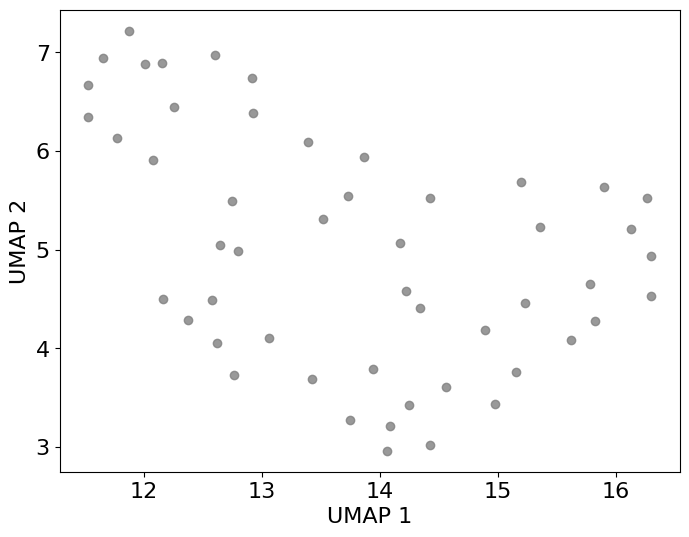

In [22]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    mouse_embedding[:, 0],
    mouse_embedding[:, 1],
    alpha=0.8,
    c='grey'  # Choose a colormap
)   #     c=mouse_name_numbers,

# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")


Text(0, 0.5, 'UMAP 2')

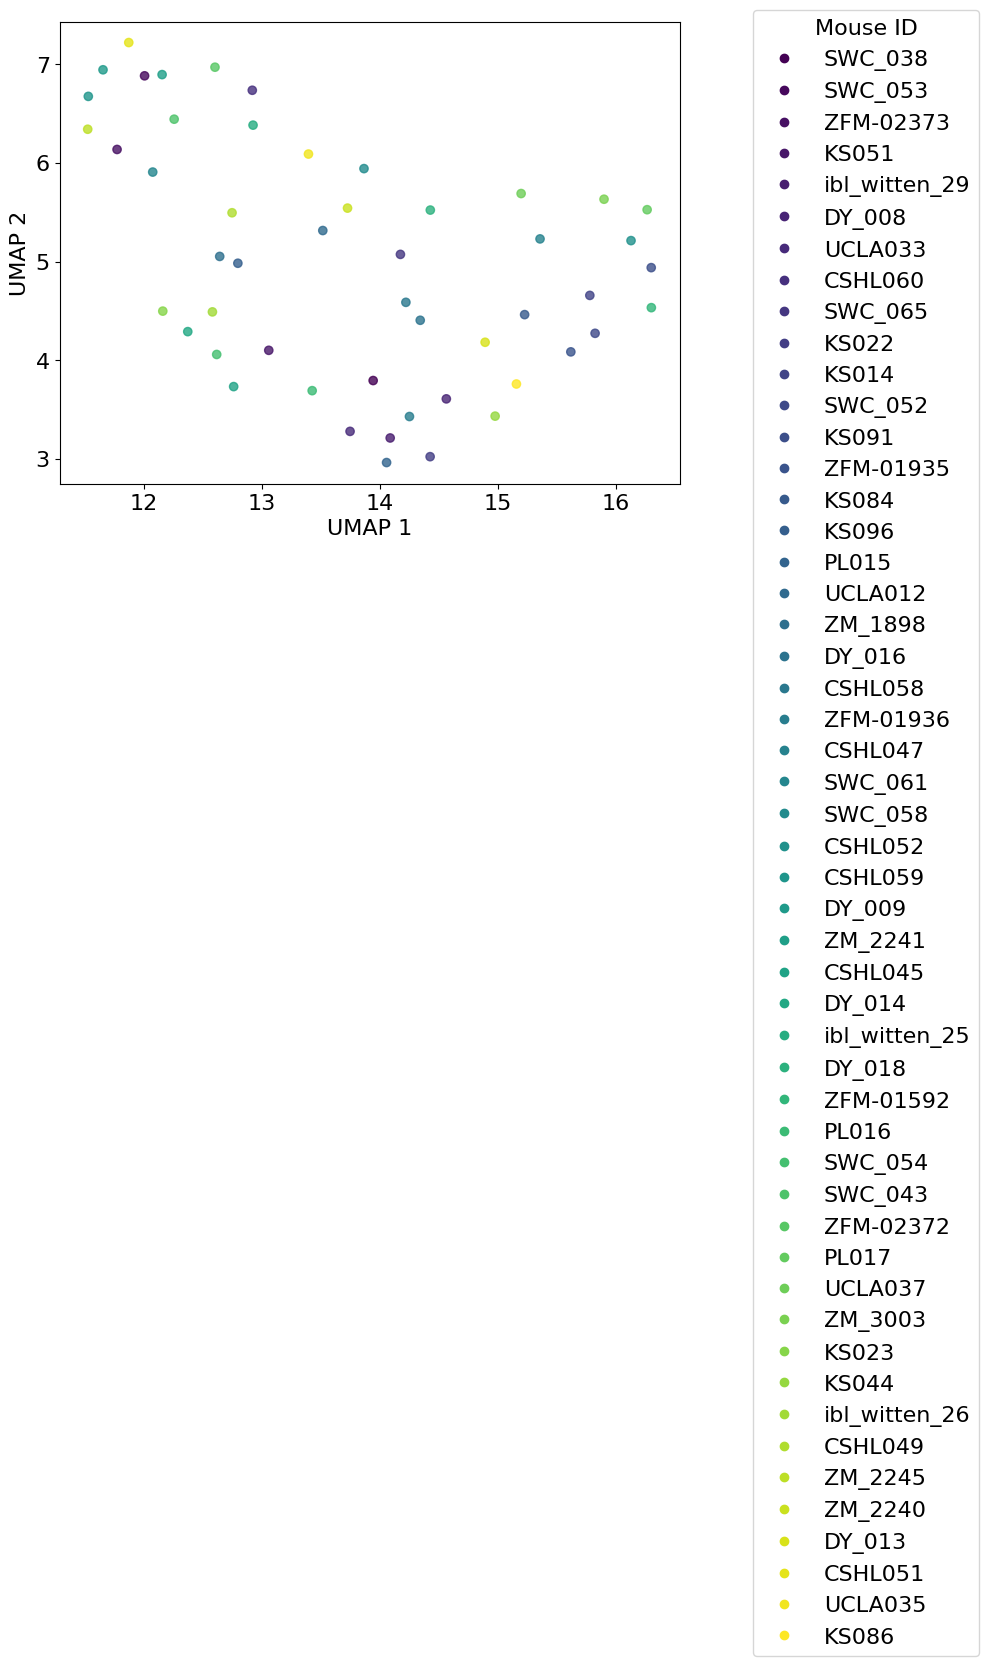

In [29]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    mouse_embedding[:, 0],
    mouse_embedding[:, 1],
    alpha=0.8,
    c=mouse_name_numbers,
    cmap='viridis'  # Choose a colormap
)   #     c=mouse_name_numbers,

# Create the custom legend
handles = []
for code, label in zip(unique_mouse_labels[:], merged_df['mouse_name'].unique()[:]):
    handles.append(plt.Line2D([], [], marker='o', color=scatter.cmap(scatter.norm(code)), linestyle='', label=label))

# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.legend(handles=handles, title="Mouse ID", bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")



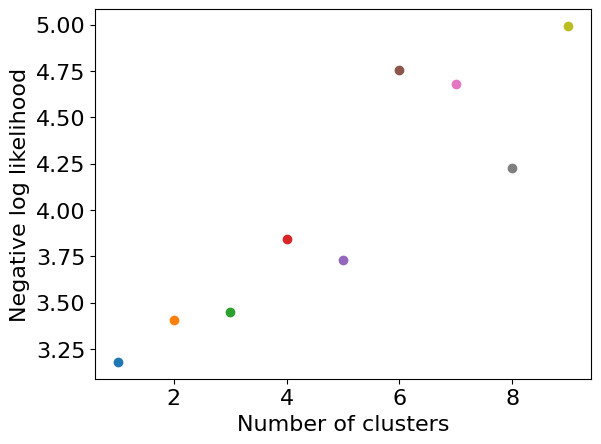

In [66]:
from sklearn import mixture

# for k in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
for k in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # g = mixture.GaussianMixture(n_components=k)
    # generate random sample, two components
    np.random.seed(0)

    # concatenate the two datasets into the final training set
    cutoff = int(np.shape(mouse_embedding)[0]*0.8)
    X_train = np.vstack([mouse_embedding[:cutoff, 0], mouse_embedding[:cutoff, 1]]).T

    # fit a Gaussian Mixture Model with two components
    clf = mixture.GaussianMixture(n_components=k, covariance_type='full')
    clf.fit(X_train)

    X_test = np.vstack([mouse_embedding[cutoff:, 0], mouse_embedding[cutoff:, 1]])
    LL = -clf.score(X_test.T)
    
    plt.scatter([k], [LL])
    plt.xlabel('Number of clusters')
    plt.ylabel('Negative log likelihood')
    plt.savefig(file_path+'NLL_mice.svg', format="svg")



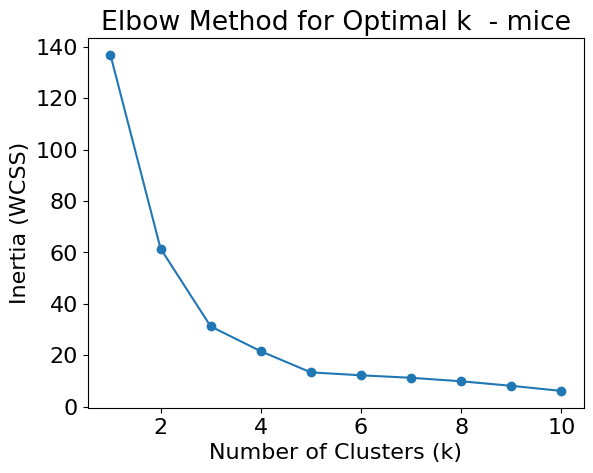

In [65]:
# Assuming `X` is your data
inertia_values = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cutoff = int(np.shape(mouse_embedding)[0]*0.8)
    X_train = np.vstack([mouse_embedding[:cutoff, 0], mouse_embedding[:cutoff, 1]]).T
    kmeans.fit(X_train)
    inertia_values.append(kmeans.inertia_)

# Plotting the inertia values
plt.plot(K, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k  - mice')
plt.savefig(file_path+'inertia_mice.svg', format="svg")

plt.show()

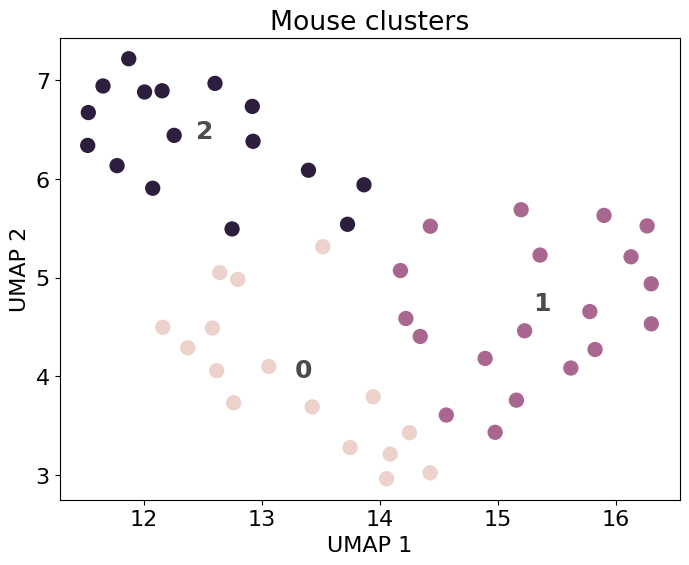

In [48]:
## K-means clustering of data
# Step 2: Perform KMeans Clustering
data_2d = mouse_embedding
kmeans = KMeans(n_clusters=3, random_state=2024)
kmeans.fit(data_2d)
mouse_y_kmeans = kmeans.predict(data_2d)

# Step 3: Plot the clusters
fig, ax = plt.subplots(figsize=(8, 6))


# Plot each cluster with a different color
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c=mouse_y_kmeans, s=100, alpha=1, cmap=sns.cubehelix_palette(as_cmap=True))#, edgecolor='black',  cmap=sns.cubehelix_palette(as_cmap=True))



centroids = kmeans.cluster_centers_
for c, cent in enumerate(centroids):
    dots = ax.text(centroids[c, 0], centroids[c, 1], str(c), c='black', alpha=0.7, fontsize=18, weight='bold')
    # plt.text(x, y, str(x), color="red", fontsize=12)

# # Plot the centroids
# centroids = kmeans.cluster_centers_
# dots = ax.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', marker='X')
# # produce a legend with the unique colors from the scatter
# legend1 = ax.legend(*scatter.legend_elements(),
#                     loc="lower right", title="Cluster")
# ax.add_artist(legend1)

plt.title("Mouse clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.savefig(file_path+'umap_mice.svg', format="svg")

plt.show()

In [24]:
freq_df['mouse_cluster'] = mouse_y_kmeans
mouse_clustered_info = count.reset_index()
mouse_clustered_info = mouse_clustered_info.merge(freq_df.reset_index()[['mouse_name', 'mouse_cluster']], on='mouse_name')

In [25]:
# mouse_clustered_info.to_pickle("./cluster_per_mouse_16oct2024.pkl")  

In [26]:
mean_cluster_mice = pd.DataFrame(mouse_clustered_info.groupby(['mouse_cluster', 'cluster'])['relative_frequency'].mean()).reset_index()


In [39]:

plt_vars = ['Right ballistic','Accurate, long pre-quiescence','Long reaction', 'Left ballistic',
            'Left non-ballistic','Right non-ballistic'] 
unique_clusters = [3, 0, 2, 1, 4, 5]
# {unique: key for unique, key in zip(state_labels, int_state)}
mapping = {
    cluster: label
    for cluster, label in zip(unique_clusters, plt_vars)
}
mapping
replace_func = np.vectorize(mapping.get)



In [27]:
new_dict = {3:0, 0:1, 2:2, 1:3, 4:4, 5:5}
replace_func = np.vectorize(new_dict.get)
mean_cluster_mice['new_clusters'] = mean_cluster_mice['cluster'].copy()
mean_cluster_mice['new_clusters'] = replace_func(mean_cluster_mice['cluster'])

In [47]:
mean_cluster_mice['label'] = mean_cluster_mice['cluster'].copy()
mean_cluster_mice['label'] = replace_func(mean_cluster_mice['label'])

mean_cluster_mice.sort_values(by='label')

mouse_cluster  cluster  relative_frequency                          label
0               0        0            0.112374  Accurate, long pre-quiescence
12              2        0            0.363768  Accurate, long pre-quiescence
6               1        0            0.076230  Accurate, long pre-quiescence
1               0        1            0.160930                 Left ballistic
13              2        1            0.149608                 Left ballistic
7               1        1            0.309713                 Left ballistic
4               0        4            0.136407             Left non-ballistic
16              2        4            0.092957             Left non-ballistic
10              1        4            0.104369             Left non-ballistic
14              2        2            0.099272                  Long reaction
8               1        2            0.135643                  Long reaction
2               0        2            0.063290                  Long reaction
3               0        3            0.380445                Right ballistic
15              2        3            0.142683                Right ballistic
9               1        3            0.250123                Right ballistic
11              1        5            0.123922            Right non-ballistic
5               0        5            0.150509            Right non-ballistic
17              2        5            0.151712            Right non-ballistic

In [49]:
mean_cluster_mice['label'] = mean_cluster_mice['cluster'].copy()
mean_cluster_mice['label'] = replace_func(mean_cluster_mice['label'])

mean_cluster_mice.sort_values(by='label')

# Custom order (array) for the 'name' column
custom_order = ['Right ballistic','Accurate, long pre-quiescence','Long reaction', 'Left ballistic',
            'Left non-ballistic','Right non-ballistic'] 

# Convert the 'name' column to a categorical type with the specified order
mean_cluster_mice['label'] = pd.Categorical(mean_cluster_mice['label'], categories=custom_order, ordered=True)


In [28]:
import plotly.express as px 
import plotly.graph_objects as go 
plt.rcParams.update({'font.size': 16})

# plot star plot for comparison 
fig = go.Figure() 
plt_vars = ['Accurate, long pre-quiescence','Left ballistic','Long reaction','Right ballistic', 
            'Left non-ballistic','Right non-ballistic'] 
plt_vars = ['Right ballistic','Accurate, long pre-quiescence','Long reaction', 'Left ballistic',
            'Left non-ballistic','Right non-ballistic'] 
# .sort_values(by='label')
fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_mice.sort_values(by='new_clusters').loc[mean_cluster_mice['mouse_cluster']==0, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Mouse cluster 0' 
)) 
fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_mice.sort_values(by='new_clusters').loc[mean_cluster_mice['mouse_cluster']==1, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Mouse cluster 1'
)) 

fig.add_trace(go.Scatterpolar( 
      r=pd.Series(mean_cluster_mice.sort_values(by='new_clusters').loc[mean_cluster_mice['mouse_cluster']==2, 'relative_frequency'].values), 
      theta=plt_vars, 
      fill='toself', 
      name='Mouse cluster 2'
)) 
  
fig.update_layout( 
  polar=dict(
        angularaxis=dict(
            tickfont=dict(size=16)  # Set the font size of the theta labels
        ),
    radialaxis=dict( 
      visible=True,
      tickfont=dict(size=16)
          )), 
  
  showlegend=True
)  #     template = 'plotly_dark', 

# plt.savefig(file_path+'star_plots_mice.svg', format="svg")
fig.write_image(file_path + 'star_plots_mice.svg')

fig.show() 

/tmp/ipykernel_6992/2780238496.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(centroids[c, 0], centroids[c, 1], edgecolor='grey', linewidth=2, c=colors[c], alpha=1, s=mean*10000)
/tmp/ipykernel_6992/2780238496.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


Text(0, 0.5, 'UMAP 2')

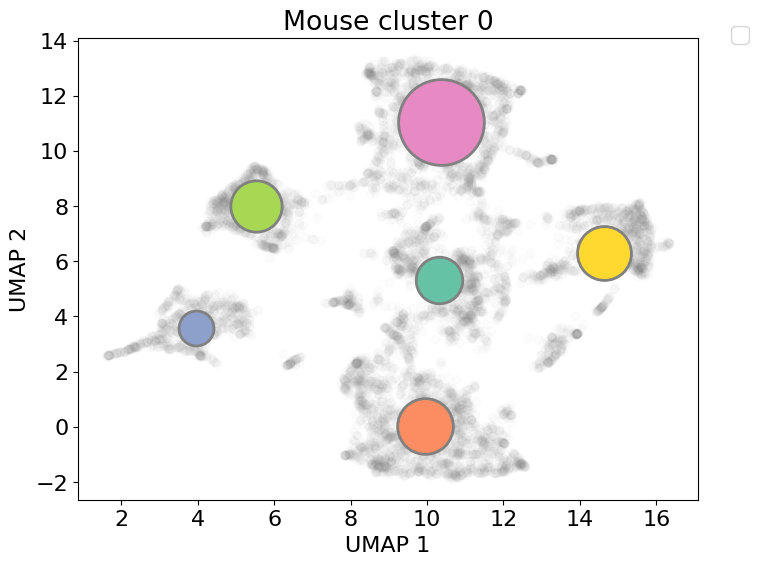

In [26]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
colors = sns.color_palette("Set2", 8)

scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.02,
    c='grey'  # Choose a colormap
)   

# Plot the centroids
centroids = kmeans_trials.cluster_centers_
for c, cent in enumerate(centroids):
    mean = mean_cluster_mice.loc[(mean_cluster_mice['mouse_cluster']==0) & 
                                     (mean_cluster_mice['cluster']==c), 'relative_frequency']
    
    plt.scatter(centroids[c, 0], centroids[c, 1], edgecolor='grey', linewidth=2, c=colors[c], alpha=1, s=mean*10000)


plt.title('Mouse cluster 0')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

/tmp/ipykernel_6992/2071605025.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(centroids[c, 0], centroids[c, 1], edgecolor='grey', linewidth=2, c=colors[c], alpha=1, s=mean*10000)
/tmp/ipykernel_6992/2071605025.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


Text(0, 0.5, 'UMAP 2')

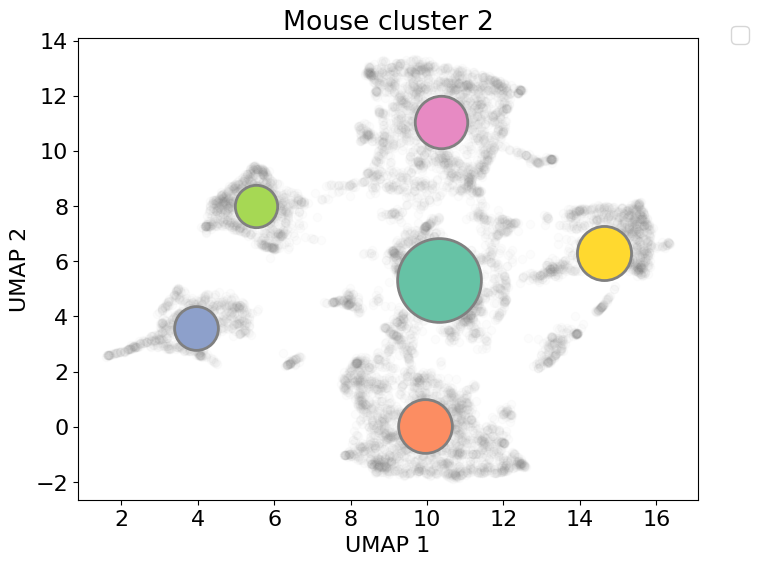

In [28]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 16})
colors = sns.color_palette("Set2", 8)

scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.02,
    c='grey'  # Choose a colormap
)   

# Plot the centroids
centroids = kmeans_trials.cluster_centers_
for c, cent in enumerate(centroids):
    mean = mean_cluster_mice.loc[(mean_cluster_mice['mouse_cluster']==2) & 
                                     (mean_cluster_mice['cluster']==c), 'relative_frequency']
    
    plt.scatter(centroids[c, 0], centroids[c, 1], edgecolor='grey', linewidth=2, c=colors[c], alpha=1, s=mean*10000)


plt.title('Mouse cluster 2')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

Text(0.5, 0, 'Mouse cluster')

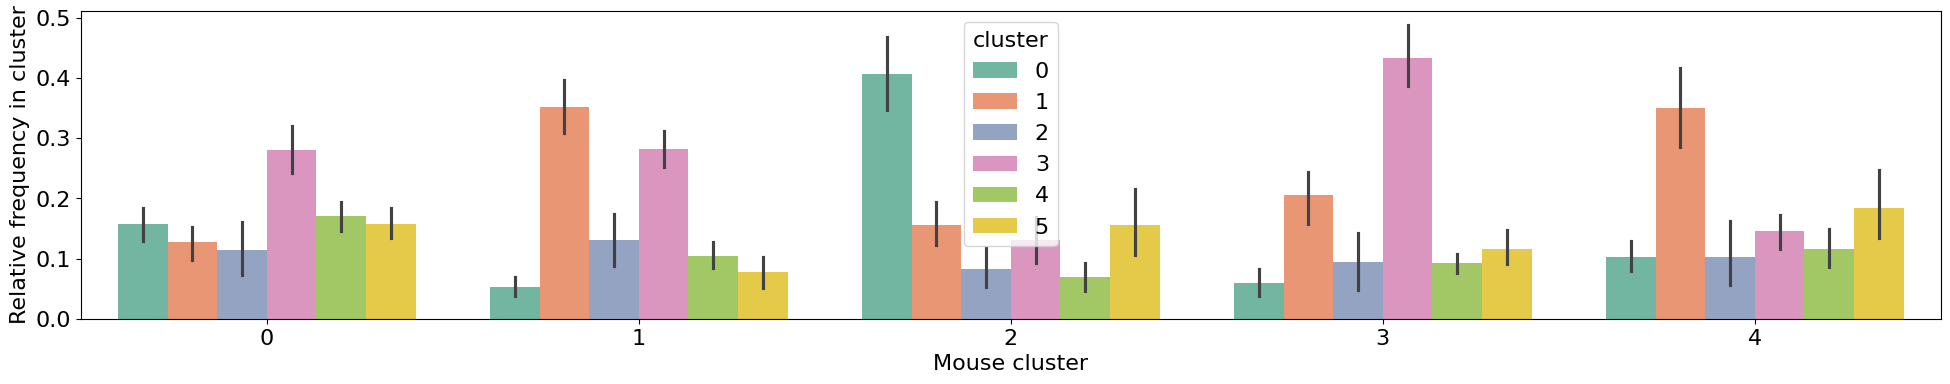

In [261]:
fig, ax = plt.subplots(figsize=(24, 4))
sns.barplot(x='mouse_cluster', y='relative_frequency', hue='cluster', data=mouse_clustered_info, palette='Set2')
plt.ylabel('Relative frequency in cluster')
plt.xlabel('Mouse cluster')

In [74]:
new_df = df_cluster.merge(mouse_clustered_info[['mouse_name', 'mouse_cluster']])

In [75]:
new_df = pd.DataFrame(new_df.groupby(['mouse_name', 'mouse_cluster', 'session'])['reaction', 'response', 'elongation', 'correct', 'ballistic'].mean()).reset_index()
new_df = pd.DataFrame(new_df.groupby(['mouse_name', 'mouse_cluster'])['reaction', 'response', 'elongation', 'correct', 'ballistic'].mean()).reset_index()

/tmp/ipykernel_8475/455807467.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/tmp/ipykernel_8475/455807467.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



/tmp/ipykernel_8475/1986622969.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_8475/1986622969.py:2: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



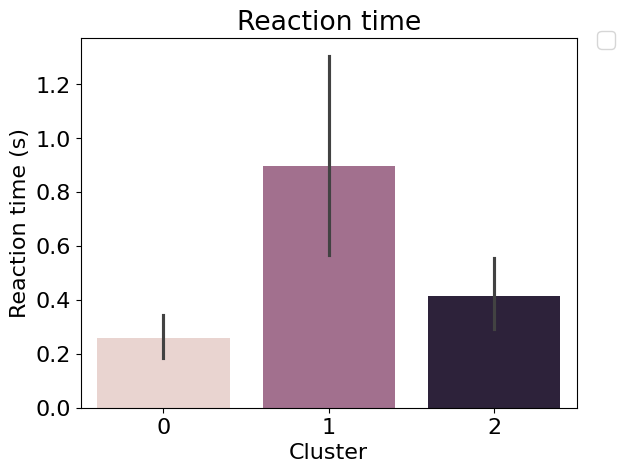

/tmp/ipykernel_8475/1986622969.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_8475/1986622969.py:11: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



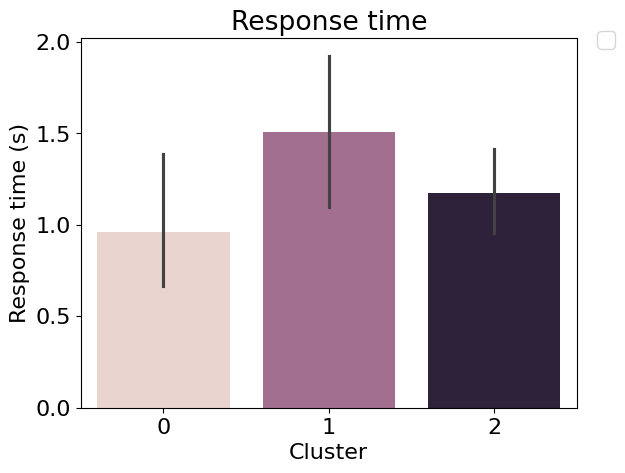

/tmp/ipykernel_8475/1986622969.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_8475/1986622969.py:20: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



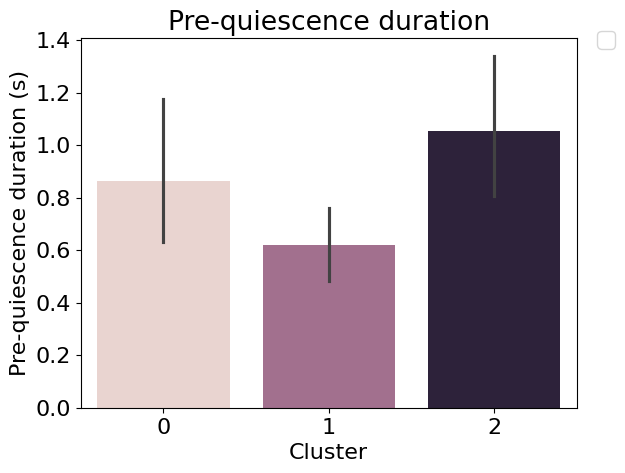

/tmp/ipykernel_8475/1986622969.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_8475/1986622969.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



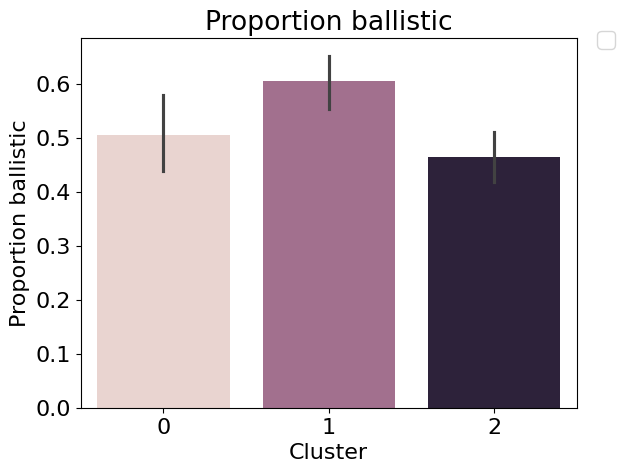

/tmp/ipykernel_8475/1986622969.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipykernel_8475/1986622969.py:38: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



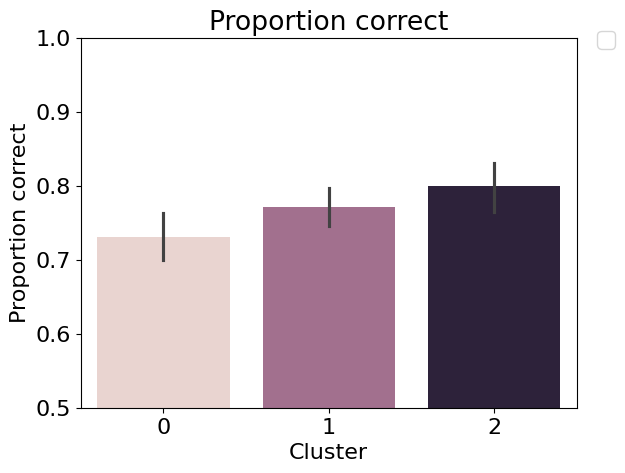

In [76]:
sns.barplot(x='mouse_cluster', y='reaction', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Reaction time')
plt.ylabel('Reaction time (s)')
plt.xlabel('Cluster')
plt.savefig(file_path+'reaction_mouse.svg', format="svg")

plt.show()

sns.barplot(x='mouse_cluster', y='response', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Response time')
plt.ylabel('Response time (s)')
plt.savefig(file_path+'response_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.show()

sns.barplot(x='mouse_cluster', y='elongation', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Pre-quiescence duration')
plt.ylabel('Pre-quiescence duration (s)')
plt.savefig(file_path+'elongation_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.show()

sns.barplot(x='mouse_cluster', y='ballistic', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion ballistic')
plt.ylabel('Proportion ballistic')
plt.savefig(file_path+'ballistic_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.show()

sns.barplot(x='mouse_cluster', y='correct', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Proportion correct')
plt.ylabel('Proportion correct')
plt.savefig(file_path+'correct_mouse.svg', format="svg")

plt.xlabel('Cluster')
plt.ylim([.5, 1])
plt.show()

# use_data = df_cluster.copy()
# use_data.loc[use_data['choice']=='left', 'choice'] = 1
# use_data.loc[use_data['choice']=='right', 'choice'] = 0
# sns.barplot(x='mouse_cluster', y='choice', data=new_df, palette=sns.cubehelix_palette(3,as_cmap=False))
# plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.title('Choice')
# plt.ylabel('Proportion choice left')
# plt.xlabel('Cluster')
# plt.show()



/tmp/ipykernel_27809/2852548276.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.1, 1.05))


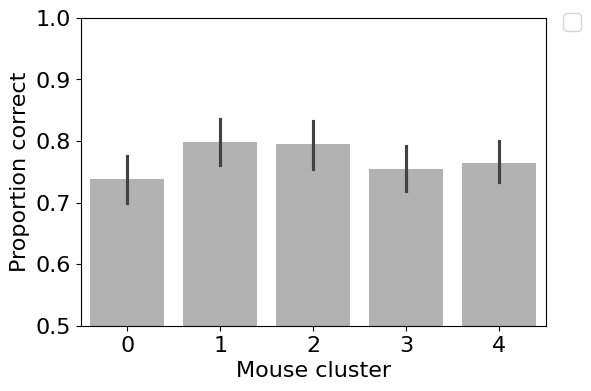

In [265]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x='mouse_cluster', y='correct', data=new_df, color='grey', alpha=0.6)
plt.legend(bbox_to_anchor=(1.1, 1.05))
# plt.title('Proportion correct')
plt.ylabel('Proportion correct')
plt.xlabel('Mouse cluster')
plt.ylim([.5, 1])
plt.show()

In [46]:
# Perform two-sample t-test
from scipy.stats import ttest_ind

group_1 = new_df.loc[new_df['mouse_cluster']==1, 'ballistic']
group_2 = new_df.loc[new_df['mouse_cluster']==2, 'ballistic']
t_stat, p_value = ttest_ind(group_1, group_2)
print(f"t-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

t-statistic: 3.880
P-value: 0.000


In [37]:
def revert_to_original(use_data):
    # Revert to original states
    use_data['original_states'] = use_data['identifiable_states'].copy()

    state = use_data.loc[use_data['original_states'].str[0]=='L', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='L', 'original_states'] = '1' + state.str[1:]

    state = use_data.loc[use_data['original_states'].str[0]=='l', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='l', 'original_states'] = '1' + state.str[1:]

    state = use_data.loc[use_data['original_states'].str[0]=='R', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='R', 'original_states'] = '1' + state.str[1:]

    state = use_data.loc[use_data['original_states'].str[0]=='r', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='r', 'original_states'] = '1' + state.str[1:]


    state = use_data.loc[use_data['original_states'].str[0]=='n', 'original_states']
    use_data.loc[use_data['original_states'].str[0]=='n', 'original_states'] = '1' + state.str[1:]
    
    return use_data

def get_ballistic(use_data):
    use_data['bal_state'] = use_data['identifiable_states'].copy()
    use_data.loc[use_data['identifiable_states'].str[0]=='L', 'bal_state'] = 'balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='R', 'bal_state'] = 'balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='l', 'bal_state'] = 'non_balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='r', 'bal_state'] = 'non_balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='n', 'bal_state'] = 'non_balistic'
    use_data.loc[use_data['identifiable_states'].str[0]=='0', 'bal_state'] = np.nan

    return use_data


def get_no_resp(use_data):
    use_data['resp'] = use_data['identifiable_states'].copy()
    use_data.loc[use_data['identifiable_states'].str[0]=='L', 'resp'] = 'response'
    use_data.loc[use_data['identifiable_states'].str[0]=='R', 'resp'] = 'response'
    use_data.loc[use_data['identifiable_states'].str[0]=='l', 'resp'] = 'response'
    use_data.loc[use_data['identifiable_states'].str[0]=='r', 'resp'] = 'response'
    use_data.loc[use_data['identifiable_states'].str[0]=='n', 'resp'] = 'non_response'
    use_data.loc[use_data['identifiable_states'].str[0]=='0', 'resp'] = np.nan

    return use_data

## Averaging sessions and mice on trial space

In [93]:
merged_df['UMAP1'] = embedding[:, 0]
merged_df['UMAP2'] = embedding[:, 1]
merged_df['cluster'] = y_kmeans_trials

mice_df = pd.DataFrame(merged_df.groupby(['mouse_name'])['UMAP1', 'UMAP2'].mean()).reset_index()
session_df = pd.DataFrame(merged_df.groupby(['mouse_name', 'session'])['UMAP1', 'UMAP2'].mean()).reset_index()
session_df = session_df.merge(mice_df, on='mouse_name')

session_df = session_df.merge(mouse_clustered_info[['mouse_name', 'mouse_cluster']], on='mouse_name')

/tmp/ipykernel_53158/2501333835.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  mice_df = pd.DataFrame(merged_df.groupby(['mouse_name'])['UMAP1', 'UMAP2'].mean()).reset_index()
/tmp/ipykernel_53158/2501333835.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  session_df = pd.DataFrame(merged_df.groupby(['mouse_name', 'session'])['UMAP1', 'UMAP2'].mean()).reset_index()


NameError: name 'all_mice' is not defined

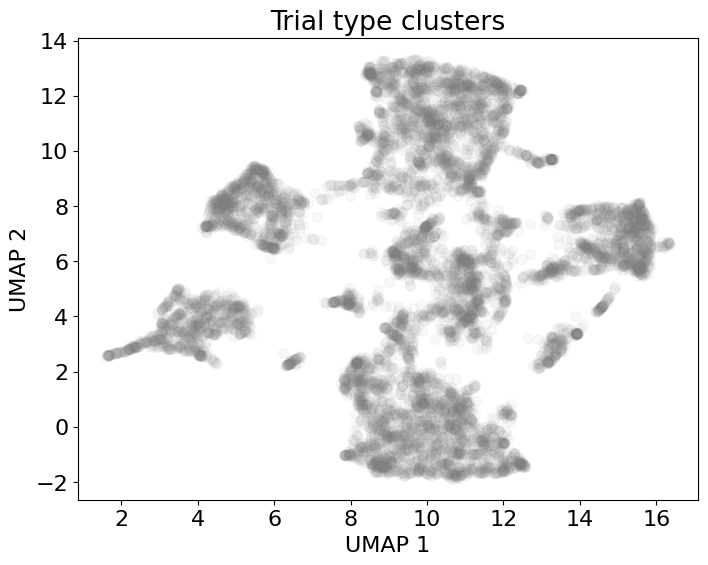

In [94]:
# Step 2: Perform KMeans Clustering
data_2d = embedding
kmeans = KMeans(n_clusters=8, random_state=2024)
kmeans.fit(data_2d)
y_kmeans = kmeans.predict(data_2d)


fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c='grey', s=50, cmap='viridis', alpha=0.05)
plt.title("Trial type clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
use_data = session_df.loc[session_df['mouse_name'].isin(all_mice)]
# m = sns.scatterplot(x='UMAP1_y', y='UMAP2_y', hue='mouse_cluster', s = 200,data=use_data)
s = sns.scatterplot(x='UMAP1_x', y='UMAP2_x', hue='mouse_cluster', edgecolor='black', s = 50, data=use_data, alpha=0.7)
# m.legend(title="Mouse name", bbox_to_anchor=(1.1, 1.05))
s.legend().set_visible(False)
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c='grey', s=50, cmap='viridis', alpha=0.05)
plt.title("Trial type clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
use_data = session_df.loc[session_df['mouse_name'].isin(all_mice)]
m = sns.scatterplot(x='UMAP1_y', y='UMAP2_y', hue='mouse_cluster', edgecolor='black', s = 100,data=use_data)
# s = sns.scatterplot(x='UMAP1_x', y='UMAP2_x', hue='mouse_cluster', s = 100, data=use_data, alpha=0.7)
# m.legend(title="Mouse name", bbox_to_anchor=(1.1, 1.05))
s.legend().set_visible(False)
plt.show()

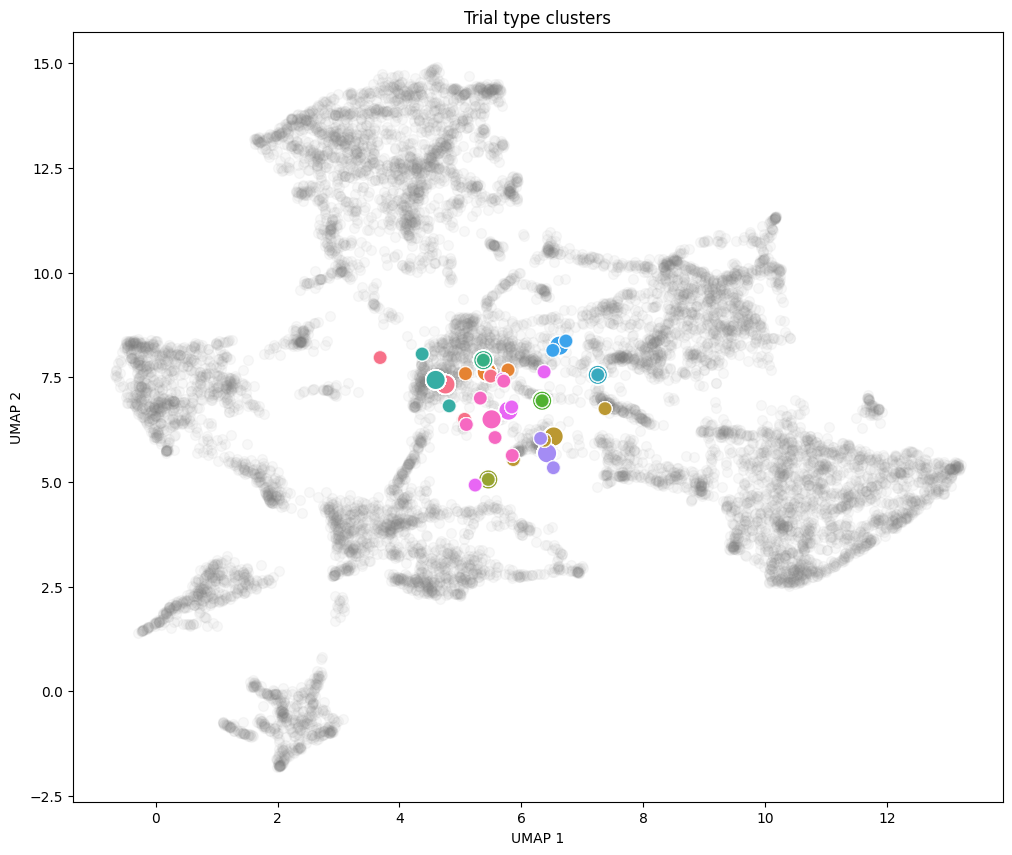

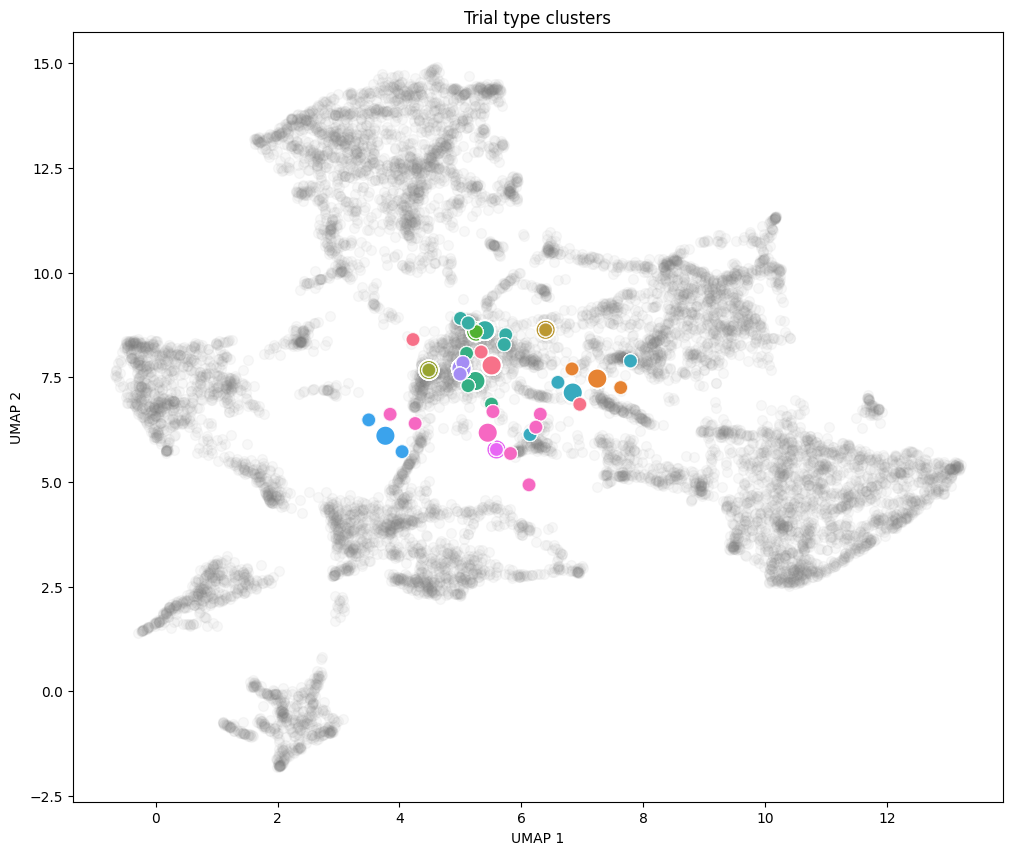

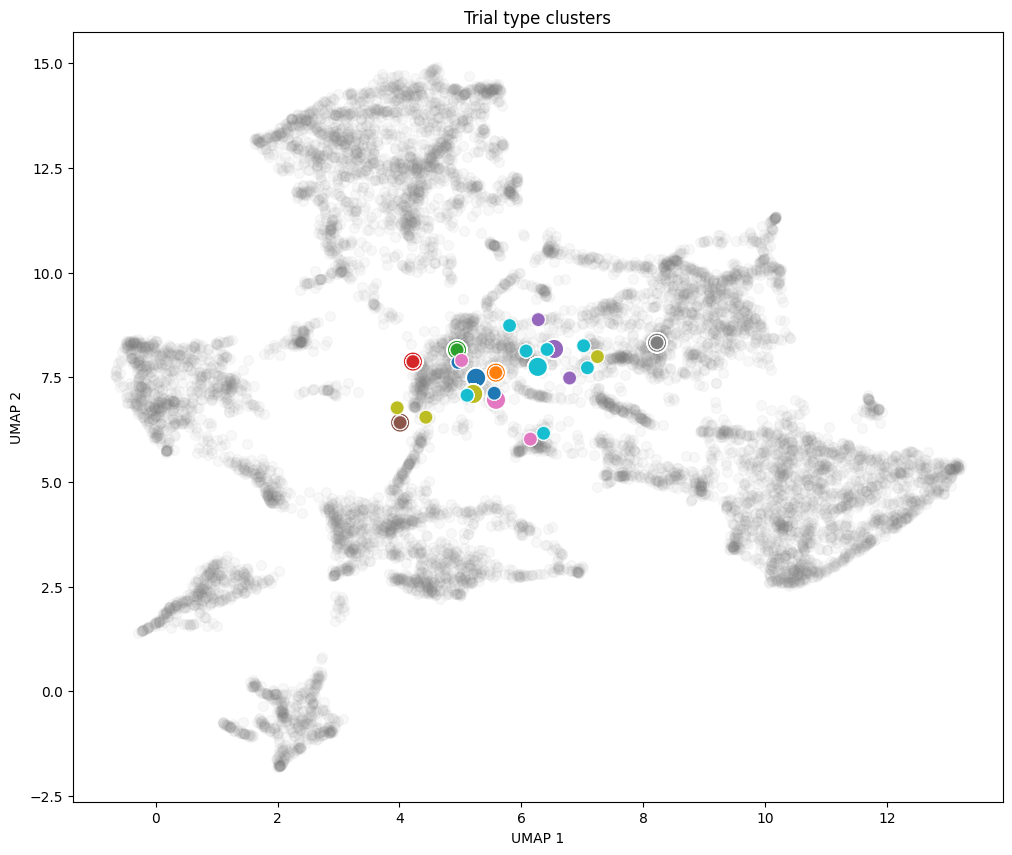

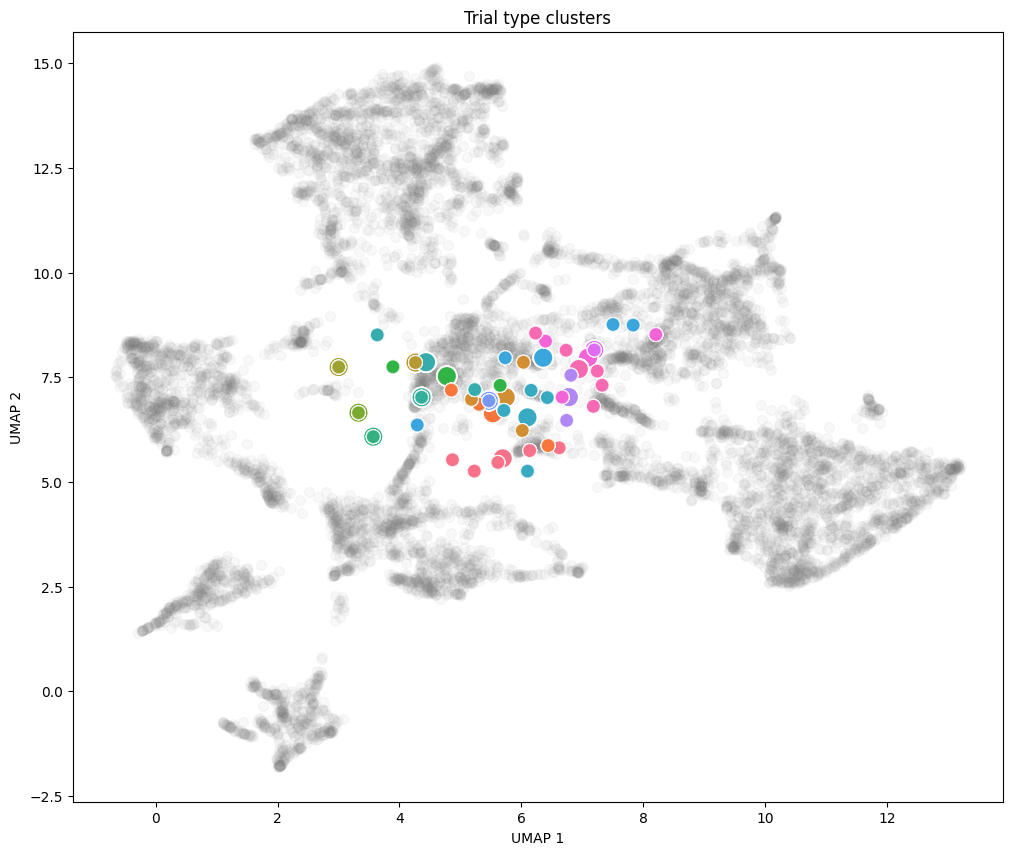

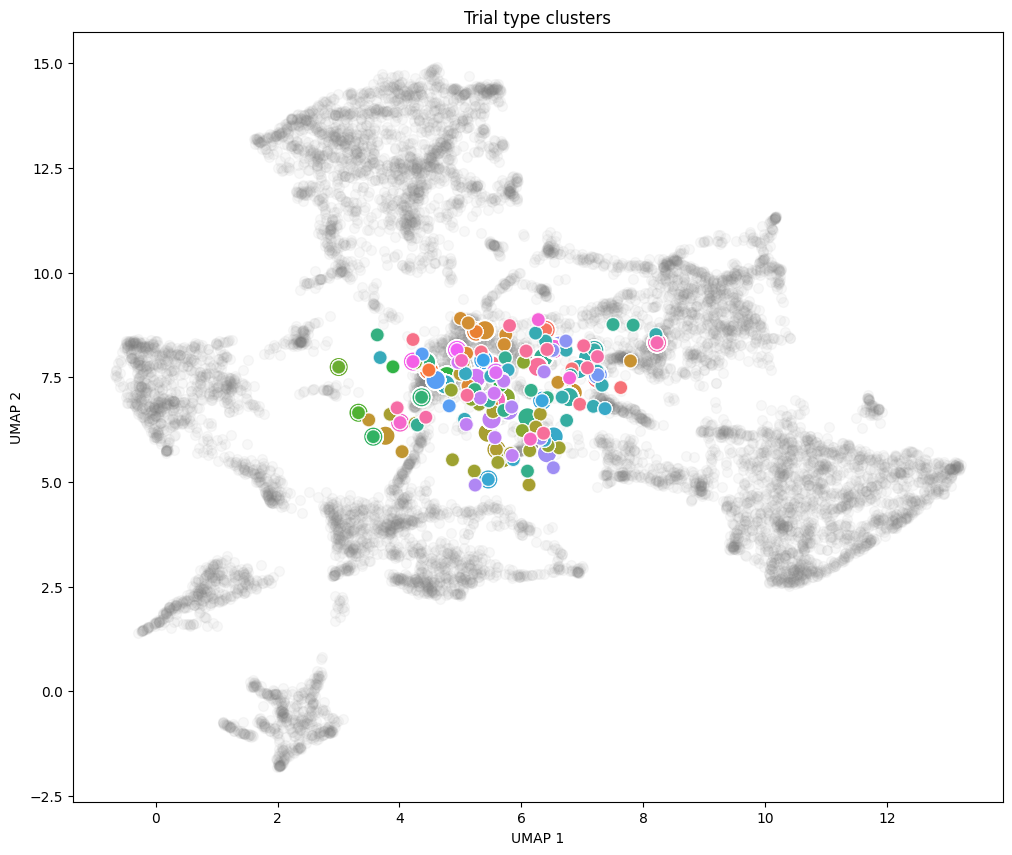

In [126]:
all_mice = ['CSHL045', 'CSHL047', 'CSHL049', 'CSHL051', 'CSHL052', 'CSHL058',
       'CSHL059', 'CSHL060', 'DY_008', 'DY_009', 'DY_013', 'DY_014',
       'DY_016', 'DY_018', 'KS014', 'KS022', 'KS023', 'KS044', 'KS051',
       'KS084', 'KS086', 'KS091', 'KS096', 'PL015', 'PL016', 'PL017',
       'SWC_038', 'SWC_043', 'SWC_052', 'SWC_053', 'SWC_054', 'SWC_058',
       'SWC_061', 'SWC_065', 'UCLA012', 'UCLA033', 'UCLA035', 'UCLA037',
       'ZFM-01592', 'ZFM-01935', 'ZFM-01936', 'ZFM-02372', 'ZFM-02373',
       'ZM_1898', 'ZM_2240', 'ZM_2241', 'ZM_2245', 'ZM_3003',
       'ibl_witten_25', 'ibl_witten_26', 'ibl_witten_29']

mice_1 = ['SWC_053', 'SWC_054', 'SWC_058',
       'SWC_061', 'SWC_065', 'UCLA012', 'UCLA033', 'UCLA035', 'UCLA037',
       'ZFM-01592', 'ZFM-01935', 'ZFM-01936']
mice_3 = ['ZFM-02372', 'ZFM-02373',
       'ZM_1898', 'ZM_2240', 'ZM_2241', 'ZM_2245', 'ZM_3003',
       'ibl_witten_25', 'ibl_witten_26', 'ibl_witten_29']
mice_2 = ['CSHL045', 'CSHL047', 'CSHL049', 'CSHL051', 'CSHL052', 'CSHL058',
       'CSHL059', 'CSHL060', 'DY_008', 'DY_009', 'DY_013', 'DY_014']
mice_4 = ['DY_016', 'DY_018', 'KS014', 'KS022', 'KS023', 'KS044', 'KS051',
       'KS084', 'KS086', 'KS091', 'KS096', 'PL015', 'PL016', 'PL017',
       'SWC_038', 'SWC_043', 'SWC_052']

# Step 2: Perform KMeans Clustering
data_2d = embedding
kmeans = KMeans(n_clusters=8, random_state=2024)
kmeans.fit(data_2d)
y_kmeans = kmeans.predict(data_2d)

fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c='grey', s=50, cmap='viridis', alpha=0.05)
plt.title("Trial type clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
use_data = session_df.loc[session_df['mouse_name'].isin(mice_1)]
m = sns.scatterplot(x='UMAP1_y', y='UMAP2_y', hue='mouse_name', s = 200,data=use_data)
s = sns.scatterplot(x='UMAP1_x', y='UMAP2_x', hue='mouse_name', s = 100, data=use_data, alpha=0.7)
# m.legend(title="Mouse name", bbox_to_anchor=(1.1, 1.05))
s.legend().set_visible(False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c='grey', s=50, cmap='viridis', alpha=0.05)
plt.title("Trial type clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
use_data = session_df.loc[session_df['mouse_name'].isin(mice_2)]
m = sns.scatterplot(x='UMAP1_y', y='UMAP2_y', hue='mouse_name', s=200, data=use_data)
s = sns.scatterplot(x='UMAP1_x', y='UMAP2_x', hue='mouse_name', s=100, data=use_data, alpha=0.7)
# m.legend(title="Mouse name", bbox_to_anchor=(1.1, 1.05))
s.legend().set_visible(False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c='grey', s=50, cmap='viridis', alpha=0.05)
plt.title("Trial type clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
use_data = session_df.loc[session_df['mouse_name'].isin(mice_3)]
m = sns.scatterplot(x='UMAP1_y', y='UMAP2_y', hue='mouse_name', s=200, data=use_data)
s = sns.scatterplot(x='UMAP1_x', y='UMAP2_x', hue='mouse_name', s=100, data=use_data, alpha=0.7)
# m.legend(title="Mouse name", bbox_to_anchor=(1.1, 1.05))
s.legend().set_visible(False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c='grey', s=50, cmap='viridis', alpha=0.05)
plt.title("Trial type clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
use_data = session_df.loc[session_df['mouse_name'].isin(mice_4)]
m = sns.scatterplot(x='UMAP1_y', y='UMAP2_y', hue='mouse_name', s=200, data=use_data)
s = sns.scatterplot(x='UMAP1_x', y='UMAP2_x', hue='mouse_name', s=100, data=use_data, alpha=0.7)
# m.legend(title="Mouse name", bbox_to_anchor=(1.1, 1.05))
s.legend().set_visible(False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(data_2d[:, 0], data_2d[:, 1], c='grey', s=50, cmap='viridis', alpha=0.05)
plt.title("Trial type clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
use_data = session_df.loc[session_df['mouse_name'].isin(all_mice)]
m = sns.scatterplot(x='UMAP1_y', y='UMAP2_y', hue='mouse_name', s = 200,data=use_data)
s = sns.scatterplot(x='UMAP1_x', y='UMAP2_x', hue='mouse_name', s = 100, data=use_data, alpha=0.7)
# m.legend(title="Mouse name", bbox_to_anchor=(1.1, 1.05))
s.legend().set_visible(False)
plt.show()
